# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.** This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Table of contents


1) [Initial EDA on portfolio.json](#initial_eda_on_potfolio)

2) [Initial EDA on profile.json](#initial_eda_on_profile)

3) [Initial EDA on transcript.json](#initial_eda_on_transcript)

4) [Verifications for BOGO and discount offers](#verifications_bogo_disc)

5) [Verifications for informational offers](#verifications_informational)

6) [Final data wrangling](#final_data_wrangling)

7) [Exploratory data analysis](#eda)

7.1)  [Cohort analysis](#eda_cohort)
    
7.1.1) [Age cohort](#age_cohort)
     
7.1.2) [Income cohort](#income_cohort)

7.2) [General view of completion of different types of offers](#general_view)

7.3) [Cluster Analysis](#cluster_analysis)

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import time
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
plt.rc('font', size=10)
import seaborn as sns
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

## 1) Initial EDA on portfolio.json <a class="anchor" id="initial_eda_on_potfolio"></a>

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.rename({'id': 'offer_id'}, axis = 1, inplace = True)

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
portfolio.shape

(10, 6)

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   offer_id    10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


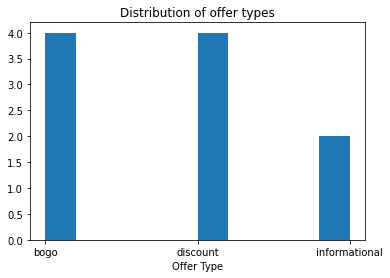

In [8]:
plt.hist(portfolio['offer_type'].sort_values());

#plt.legend();
plt.xlabel('Offer Type');
plt.title('Distribution of offer types');

In [9]:
# convert channels to dummy vars
portfolio['email'] = portfolio['channels'].apply(lambda x: int('email' in x))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int('mobile' in x))
portfolio['social'] = portfolio['channels'].apply(lambda x: int('social' in x))
portfolio['web'] = portfolio['channels'].apply(lambda x: int('web' in x))

portfolio.drop('channels', inplace = True, axis = 1)

# get dummies for offer_type column
df_cat = pd.get_dummies(portfolio['offer_type'], dummy_na = False, drop_first=True)
portfolio = portfolio.merge(df_cat, how = 'inner', left_index = True, right_index= True)
portfolio

# convert offer duration from days to hours
portfolio['duration_hours'] = portfolio['duration'].apply(lambda x: x) * 24

In [10]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,discount,informational,duration_hours
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,0,0,168
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,0,120
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,1,96
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,0,0,168
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,1,0,240
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1,0,168
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,0,240
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,1,72
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,0,0,120
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,1,0,168


## Conversion functions for portfolio.json

In [11]:
def portfolio_time_offer_dict(portfolio=portfolio):
    return pd.Series(portfolio.duration_hours.values,index=portfolio.offer_id).to_dict()

In [12]:
def portfolio_offerid_name_dict(portfolio=portfolio):
    return pd.Series(portfolio.offer_type.values,index=portfolio.offer_id).to_dict()

In [13]:
time_offer_dict = portfolio_time_offer_dict()

In [14]:
time_offer_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 168,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 120,
 '3f207df678b143eea3cee63160fa8bed': 96,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 168,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 240,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 168,
 'fafdcd668e3743c1bb461111dcafc2a4': 240,
 '5a8bc65990b245e5a138643cd4eb9837': 72,
 'f19421c1d4aa40978ebb69ca19b0e20d': 120,
 '2906b810c7d4411798c6938adc9daaa5': 168}

In [15]:
offerid_name_dict = portfolio_offerid_name_dict()

In [16]:
offerid_name_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo',
 '3f207df678b143eea3cee63160fa8bed': 'informational',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount',
 'fafdcd668e3743c1bb461111dcafc2a4': 'discount',
 '5a8bc65990b245e5a138643cd4eb9837': 'informational',
 'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo',
 '2906b810c7d4411798c6938adc9daaa5': 'discount'}

In [17]:
def offerid_to_number(portfolio=portfolio):
    
    offerid_to_number = {}
    counter = 1
    for offer_id in portfolio.offer_id:
        offerid_to_number[offer_id] = counter
        counter += 1
    return offerid_to_number

In [18]:
offerid_to_number = offerid_to_number()

In [19]:
offerid_to_number

{'ae264e3637204a6fb9bb56bc8210ddfd': 1,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '5a8bc65990b245e5a138643cd4eb9837': 8,
 'f19421c1d4aa40978ebb69ca19b0e20d': 9,
 '2906b810c7d4411798c6938adc9daaa5': 10}

## 2) Initial EDA on profile.json <a class="anchor" id="initial_eda_on_profile"></a>

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [20]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [21]:
profile.rename({'id': 'customer_id'}, axis = 1, inplace = True)

In [22]:
profile.shape

(17000, 5)

In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   customer_id       17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [24]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

A max number for age of 118 seems strange

In [25]:
profile[profile['age'] > 73]['age'].describe()

count    4177.000000
mean      100.570505
std        18.671461
min        74.000000
25%        81.000000
50%       118.000000
75%       118.000000
max       118.000000
Name: age, dtype: float64

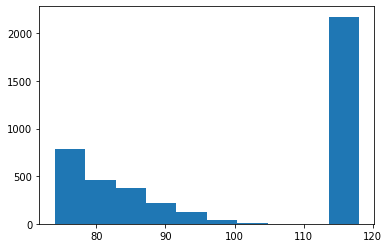

In [26]:
plt.hist(profile[profile['age'] > 73]['age']);

In [27]:
profile[profile['age'] == 118]

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [28]:
total_118 = profile[profile['age'] == 118].shape[0]
total_obs = profile.shape[0]

print('The number of observations that have age equals 118 represent {:.2f} % of all observations'.format(total_118/total_obs*100))



The number of observations that have age equals 118 represent 12.79 % of all observations


Therefore we will drop these inputs as 12.79% is not so representative and we are missing info

In [29]:
profile = profile[profile['age'] != 118]

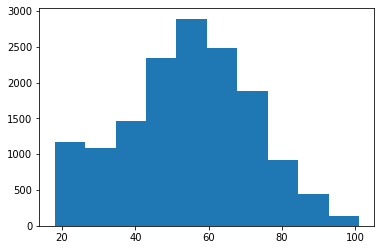

In [30]:
plt.hist(profile['age']);

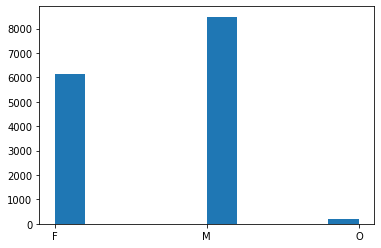

In [31]:
plt.hist(profile['gender']);

In [32]:
profile.isna().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

In [33]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['year_joined'] = profile['became_member_on'].dt.year

In [34]:
profile.head()

,gender,age,customer_id,became_member_on,income,year_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017


In [35]:
def customerid_to_number(profile=profile):
    
    customerid_to_number = {}
    counter = 1
    for customer_id in profile.customer_id:
        customerid_to_number[customer_id] = counter
        counter += 1
    return customerid_to_number

In [36]:
customerid_to_number = customerid_to_number()

In [37]:
#customerid_to_number

## 3) Initial EDA on transcript.json <a class="anchor" id="initial_eda_on_transcript"></a>

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [38]:
transcript.head(-50)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306479,2538662ed6de430bbfffbc230a12d740,transaction,{'amount': 1.35},714
306480,df174695a030444a824c11fd117d13a3,transaction,{'amount': 14.02},714
306481,1699f732aae74e71bcb7f1384cc88fde,transaction,{'amount': 21.25},714
306482,ce5e7e527e4b4ee09d4c6af1f7e561b0,transaction,{'amount': 13.56},714


In [39]:
transcript.rename({'person': 'customer_id'}, axis = 1, inplace = True)

In [40]:
transcript.tail(20)

,customer_id,event,value,time
306514,f1e4fd36e5a0446f83861308bddf6945,transaction,{'amount': 8.2},714
306515,0b64be3b241c4407a5c9a71781173829,transaction,{'amount': 2.6},714
306516,86d03d35d7e0434b935e7743e83be3a0,transaction,{'amount': 9.2},714
306517,3408fd05c781401f8442fb6dbaaea9c7,transaction,{'amount': 11.7},714
306518,1593d617fac246ef8e50dbb0ffd77f5f,transaction,{'amount': 40.67},714
306519,f1b31d07b5d84f69a2d5f1d07843989e,transaction,{'amount': 31.13},714
306520,2ce987015ec0404a97ba333e8e814090,transaction,{'amount': 1.6400000000000001},714
306521,2e33545f0a764d27b2ccff95fc8d72c4,transaction,{'amount': 17.35},714
306522,d1c4500ace2e45e9a45d3cd2fccac8d8,transaction,{'amount': 4.42},714
306523,b65affd9e07346a1906364a396950e3d,transaction,{'amount': 18.35},714


In [41]:
transcript[transcript['event'] == 'offer completed']['value'].iloc[1]

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

In [42]:
transcript.shape

(306534, 4)

In [43]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  306534 non-null  object
 1   event        306534 non-null  object
 2   value        306534 non-null  object
 3   time         306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [44]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

This dataframe will be split in two: one comprising only transaction info and other offer info. This will facilitate the analysis of whether each offer was received, viewed and completed

In [45]:
offer_df = transcript[transcript['event'] != 'transaction' ]
transaction_df = transcript[transcript['event'] == 'transaction' ]

In [46]:
transaction_df.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


## Data wrangling on different types of offers

In [47]:
amount = transaction_df.value.apply(pd.Series)
amount_df = pd.concat([transaction_df, amount], axis=1)
del amount_df['event']
del amount_df['value']
amount_df

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,a00058cf10334a308c68e7631c529907,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


In [48]:
df_amount = amount_df.groupby('customer_id')['amount'].sum().sort_values(ascending = False).reset_index()
df_amount

,customer_id,amount
0,3c8d541112a74af99e88abbd0692f00e,1608.69
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
2,ae6f43089b674728a50b8727252d3305,1327.74
3,626df8678e2a4953b9098246418c9cfa,1321.42
4,73afdeca19e349b98f09e928644610f8,1319.97
...,...,...
16573,37ca07481c124d98ac1eaca5ee1f4146,0.10
16574,999338157fd54f639b089cef0038e06a,0.05
16575,fc3444ae44044a218e160522f7de8d8d,0.05
16576,4828b93dd6dd44eb9ec8417f0564a9b9,0.05


In [49]:
#df.codes.apply(pd.Series)
value = offer_df.value.apply(pd.Series)

In [50]:
offer_df = pd.concat([offer_df, value], axis=1)

In [51]:
offer_df['offer_id'].fillna(offer_df['offer id'], inplace=True)
del offer_df['offer id']
offer_df['reward'].fillna(0, inplace=True)
del offer_df['value']

In [52]:
offer_df.head()

,customer_id,event,time,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [53]:
#get unique customer_id list
customer_ids = offer_df.customer_id.unique().tolist()

In [54]:
offer_dummies = pd.get_dummies(offer_df['event'], dummy_na = False)

In [55]:
offer_df = pd.concat([offer_df, offer_dummies], axis=1)

In [56]:
offer_df.head()

,customer_id,event,time,offer_id,reward,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0


In [57]:
offer_df['offer'] = offer_df['offer_id'].map(offerid_to_number)
offer_df['customer'] = offer_df['customer_id'].map(customerid_to_number)
offer_df['theoretical_offer_time'] = offer_df['offer_id'].map(time_offer_dict)
del offer_df['offer_id']

In [58]:
offer_df.head()

,customer_id,event,time,reward,offer completed,offer received,offer viewed,offer,customer,theoretical_offer_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0,1,0,4,2.0,168
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0,1,0,5,NaN,240
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0,1,0,10,3.0,168
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0,1,0,7,NaN,240
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0,1,0,2,NaN,120


In [59]:
offer_df.shape

(167581, 10)

In [60]:
offer_df = offer_df.dropna() #The NaNs are the customers with age = 118; we will drop them.

In [61]:
offer_df.shape

(148805, 10)

In [62]:
df_rewards = offer_df.groupby('customer_id')['reward'].sum().sort_values(ascending = False).reset_index()
df_rewards

,customer_id,reward
0,d3209835a40a423fbf2c967218d00bcd,55.0
1,7f27070d07eb44cb89b9a547074ca343,50.0
2,1acb3e87e3304271a3c917cc80a53780,50.0
3,bd920b7b033d42fb9d97be92343a9aef,50.0
4,e130d81685ae45deb9fbf6d416084a1d,50.0
...,...,...
14815,99129a5d44304888a2156e5c923cfed6,0.0
14816,d24391f6da3040319f2bef0efba30dc3,0.0
14817,3d50b3815c8e4f3b84f46be4d1b64cd3,0.0
14818,993cd91b565c490c8be6373f876f1d09,0.0


Informational offers do not register offer as completed by default; we will need to check if a transaction was made during the offer period

Rascunho de ideia para mapear se a oferta foi recebida, vista e completada:

- para cada customer_id na lista unica de customer_ids gerada:

- filtra o df nesse id para facilitar o processamento -> df.query('customer_id == @id')

- filtrar quais offers foram recebidas, vistas e completadas direto numa query? Parece que não dá

- verificar a questão do tempo

Fluxo natural: a oferta ser recebida, vista e completada (received, viewed and completed)

Precisamos lembrar da questão do tempo: ver se o ciclo foi completo dentro da theoretical time da offer

In [63]:
#Smaller sample of customer ids for validating the functions that will follow

customer_ids1 = ['78afa995795e4d85b5d9ceeca43f5fef',
'a03223e636434f42ac4c3df47e8bac43',
'e2127556f4f64592b11af22de27a7932',            
'0009655768c64bdeb2e877511632db8f',
'0020c2b971eb4e9188eac86d93036a77',
'003d66b6608740288d6cc97a6903f4f0',
'fff8957ea8b240a6b5e634b6ee8eafcf']

In [64]:
sample = offer_df.groupby(['customer_id', 'offer']).sum().reset_index()
sample.tail(15)

,customer_id,offer,time,reward,offer completed,offer received,offer viewed,customer,theoretical_offer_time
55207,fff3ba4757bd42088c044ca26d73817a,10,1512,2.0,1,2,0,13719.0,504
55208,fff7576017104bcc8677a8d63322b5e1,1,822,0.0,0,1,1,11070.0,336
55209,fff7576017104bcc8677a8d63322b5e1,2,348,0.0,0,1,1,11070.0,240
55210,fff7576017104bcc8677a8d63322b5e1,4,1170,5.0,1,1,0,11070.0,336
55211,fff7576017104bcc8677a8d63322b5e1,7,1836,4.0,2,2,2,33210.0,1440
55212,fff8957ea8b240a6b5e634b6ee8eafcf,2,1236,0.0,0,1,1,2758.0,240
55213,fff8957ea8b240a6b5e634b6ee8eafcf,3,504,0.0,0,1,0,1379.0,96
55214,fff8957ea8b240a6b5e634b6ee8eafcf,7,840,0.0,0,1,1,2758.0,480
55215,fffad4f4828548d1b5583907f2e9906b,4,1830,5.0,1,1,1,651.0,504
55216,fffad4f4828548d1b5583907f2e9906b,8,336,0.0,0,1,1,434.0,144


## 4) Verifications for BOGO and discount offers <a class="anchor" id="verifications_bogo_disc"></a>

In [65]:
def offer_3step_verification(offer_df = offer_df, customer_ids = customer_ids):
    
    "Valid for bogo and discount offers only - this will check which offers were actually received and viewed and completed - full process"
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    offer_df - dataframe with logs of offers interactions
    
    
    OUTPUT
    --------
    completed_offers - dictionary of dictionary for each customer containing
                                    offer id as a key and number of times the offer was
                                    completed as value
    
    ------
    Function takes the offer_df dataframe and returns dictionary with info about how many
    times the corresponding offer was completed by each customer following full process
    of: receiving, viewing and completing the offer - valid only for bogo and discount
    '''  
    
    offer_df = offer_df[~offer_df['offer'].isin([3,8])]
        
    completed_offers = {}

    unique_offers = [1,2,4,5,6,7,9,10]
    
    for customer in tqdm(customer_ids, desc="Generating dictionary..."):
        df = offer_df.query('customer_id == @customer')
        offer_count_dict = {}
        for offer in unique_offers:
            df1 = df.query('offer == @offer')
            df2 = df1.groupby('offer').sum().reset_index()
            if ((df2['offer received'] == 1).empty == False & ((df2['offer viewed'] == 1).empty == False) & ((df2['offer completed'] == 1).empty == False)) == True:
                if ((df2['offer completed'] == df2['offer received']) & (df2['offer completed'] == df2['offer viewed']) & (df2['offer received'] == df2['offer viewed']) == 1).values[0] == True:
                    offer_count_dict['offer_'+str(offer)+ '_complete'] = df2['offer completed'].values[0]
                else:
                    if df2['offer viewed'].values[0] > 0:
                        offer_count_dict['offer_'+str(offer)+ '_complete'] = df2['offer viewed'].values[0]
                    else:
                        offer_count_dict['offer_'+str(offer)+ '_complete'] = 0
            else:
                offer_count_dict['offer_'+str(offer)+ '_complete'] = 0
        completed_offers[customer] = offer_count_dict
        
        
    return completed_offers

In [66]:
startTime = time.time()

offers = offer_3step_verification(offer_df = offer_df, customer_ids = customer_ids)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Generating dictionary...: 100%|██████████| 16994/16994 [12:40<00:00, 22.36it/s]

Execution time in seconds: 760.2190968990326


In [67]:
#offers

Starbucks is also interested in knowing which customers that get “offer completed” flag without actually “completing” the offer, ie users who complete the offer without actually viewing the offer. The next functions maps these cases

**You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

In [68]:
def accident_completion(offer_df = offer_df, customer_ids = customer_ids):
    
    "Valid for bogo and discount offers only - this will check which offers were received but not viewed and completed"
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    offer_df - dataframe with logs of offers interactions
    
    
    OUTPUT
    --------
    accident_completion_offers - dictionary of dictionary for each customer containing
                                    offer id as a key and number of times the offer was
                                    completed as value
    
    ------
    Function takes the offer_df dataframe and returns dictionary with info about how many
    times the corresponding offer was accidentaly completed by each customer, that is: the customer complete the offer
    without actually seeing it. 
    '''  
    
    offer_df = offer_df[~offer_df['offer'].isin([3,8])]
        
    accident_completion_offers = {}

    unique_offers = [1,2,4,5,6,7,9,10]
    
    for customer in tqdm(customer_ids, desc="Generating dictionary..."):
        df = offer_df.query('customer_id == @customer')
        offer_count_dict = {}
        for offer in unique_offers:
            df1 = df.query('offer == @offer')
            df2 = df1.groupby('offer').sum().reset_index()
            if ((df2['offer received'] == 1).empty == False & ((df2['offer viewed'] == 1).empty == False) & ((df2['offer completed'] == 1).empty == False)) == True:
                if ((df2['offer completed'] == df2['offer received']) & (df2['offer completed'] != df2['offer viewed']) & (df2['offer received'] != df2['offer viewed']) == 1).values[0] == True:
                    offer_count_dict['accident_'+str(offer)] = df2['offer completed'].values[0]
                else:
                    offer_count_dict['accident_'+str(offer)] = 0
            else:
                offer_count_dict['accident_'+str(offer)] = 0
        accident_completion_offers[customer] = offer_count_dict
        
        
    return accident_completion_offers

In [69]:
startTime = time.time()

offers_accidental = accident_completion(offer_df = offer_df, customer_ids = customer_ids)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Generating dictionary...: 100%|██████████| 16994/16994 [12:17<00:00, 23.05it/s]

Execution time in seconds: 737.1893389225006


In [70]:
#offers_accidental

There is also the case of ignored offers: users who viewed the offer, but did not complete it.

**Case 1** would be count of received offers, that were not viewed. It is not worth analysing further this case because the user never got to see the offer

**Case 2**  would be the count of viewed offers, that were not completed. This is important because the offer was viewed, it means the person could estimate whether or not they wanted to pursue it.

In [71]:
def ignored_offers(offer_df = offer_df, customer_ids = customer_ids):
    
    "Valid for bogo and discount offers only - this will check which offers were received and viewed but not completed"
    
    offer_df = offer_df[~offer_df['offer'].isin([3,8])]
        
    ignored_offers = {}

    unique_offers = [1,2,4,5,6,7,9,10]
    
    for customer in tqdm(customer_ids, desc="Generating dictionary..."):
        df = offer_df.query('customer_id == @customer')
        offer_count_dict = {}
        for offer in unique_offers:
            df1 = df.query('offer == @offer')
            df2 = df1.groupby('offer').sum().reset_index()
            if ((df2['offer received'] == 1).empty == False & ((df2['offer viewed'] == 1).empty == False) & ((df2['offer completed'] == 1).empty == False)) == True:
                if ((df2['offer completed'] != df2['offer received']) & (df2['offer completed'] != df2['offer viewed']) & (df2['offer received'] == df2['offer viewed']) == 1).values[0] == True:
                    offer_count_dict['ignored_'+str(offer)] = df2['offer viewed'].values[0]
                else:
                    offer_count_dict['ignored_'+str(offer)] = 0
            else:
                offer_count_dict['ignored_'+str(offer)] = 0
        ignored_offers[customer] = offer_count_dict
        
        
    return ignored_offers

In [72]:
startTime = time.time()

ignoredoffers = ignored_offers(offer_df = offer_df, customer_ids = customer_ids)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Generating dictionary...: 100%|██████████| 16994/16994 [12:15<00:00, 23.09it/s]

Execution time in seconds: 735.8565242290497


In [73]:
#ignoredoffers

**You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

## 5) Verifications for informational offers <a class="anchor" id="verifications_discont"></a>

In [74]:
offer_df_info = offer_df[offer_df['offer'].isin([3,8])]
print(offer_df_info.shape)
offer_df_info.head()

(22660, 10)


,customer_id,event,time,reward,offer completed,offer received,offer viewed,offer,customer,theoretical_offer_time
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,0.0,0,1,0,3,5.0,96
13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,0.0,0,1,0,3,14.0,96
31,be8a5d1981a2458d90b255ddc7e0d174,offer received,0,0.0,0,1,0,8,34.0,72
44,a5a6ef2b78a04ddc9f374dd7c7f60bff,offer received,0,0.0,0,1,0,8,49.0,72
53,6e04a90a0e074496b5f229eb1f553433,offer received,0,0.0,0,1,0,8,64.0,72


In [75]:
df3 = offer_df_info[offer_df_info['offer viewed'] > 0]
df3

,customer_id,event,time,reward,offer completed,offer received,offer viewed,offer,customer,theoretical_offer_time
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,0.0,0,0,1,8,21.0,72
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,0.0,0,0,1,8,34.0,72
12667,1a353048b0884fc5a0afa27677ef1e80,offer viewed,0,0.0,0,0,1,8,97.0,72
12673,c863af14b3654499b1caea5e640136d2,offer viewed,0,0.0,0,0,1,8,126.0,72
12685,e737ff591120415581ddbe817b8c82ca,offer viewed,0,0.0,0,0,1,8,187.0,72
...,...,...,...,...,...,...,...,...,...,...
306419,5a3f7fcb450a4cb693ab5267b4d49b40,offer viewed,714,0.0,0,0,1,8,13502.0,72
306433,ec1761735b034ae8874bc979f0cd5862,offer viewed,714,0.0,0,0,1,8,13702.0,72
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,714,0.0,0,0,1,3,13897.0,96
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,0.0,0,0,1,8,14329.0,72


In [76]:
df4 = df3.query('customer_id == "d1ede868e29245ea91818a903fec04c6"')
df4

,customer_id,event,time,reward,offer completed,offer received,offer viewed,offer,customer,theoretical_offer_time
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,0.0,0,0,1,8,21.0,72


In [77]:
offer_df_info.groupby('customer_id').sum()

,time,reward,offer completed,offer received,offer viewed,offer,customer,theoretical_offer_time
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,1068,0.0,0,2,2,22,13120.0,336
0011e0d4e6b944f998e987f904e8c1e5,696,0.0,0,2,2,22,14560.0,336
0020c2b971eb4e9188eac86d93036a77,1164,0.0,0,1,1,16,4442.0,144
0020ccbbb6d84e358d3414a3ff76cffd,816,0.0,0,1,1,16,14696.0,144
003d66b6608740288d6cc97a6903f4f0,744,0.0,0,2,2,22,35312.0,336
...,...,...,...,...,...,...,...,...
ffeaa02452ef451082a0361c3ca62ef5,1194,0.0,0,2,2,32,48556.0,288
fff0f0aac6c547b9b263080f09a5586a,1668,0.0,0,2,2,12,50600.0,384
fff3ba4757bd42088c044ca26d73817a,1380,0.0,0,2,1,24,13719.0,216


In [78]:
info_offers = [3,8] # informational offers

In [79]:
def offer_time_verification(offer_df = offer_df, customer_ids = customer_ids):
        
        
    "Valid for informational offers only"
    
    '''
    INPUT
    --------
    customer_ids - list of customer IDs
    offer_df - dataframe with logs of offers interactions
    
    
    OUTPUT
    --------
    time_offer_dict - dictionary of dictionary: for each informational offer id will yield a tuple of time results
    which are the time the customer viewed the offer (t0) and which is theoretical end time of offer (tf) calculated by
    adding the theoretical_offer_time (taken from profile dataframe) to t0. Afterwards we will check if any transactions
    were made between these 2 times
    
    '''  
        
    offer_df = offer_df[offer_df['offer'].isin([3,8])]
    offer_df = offer_df[offer_df['offer viewed'] > 0]
        
    time_offer_dict = {}
        
    for customer in tqdm(customer_ids):
        offer_count_dict = {}
        #times = []
        df = offer_df.query('customer_id == @customer')
        for offer in [3,8]:
            times = []
            df1 = df.query('offer == @offer')
            for index, row in df.iterrows():
                times.append(row['time'])
                times.append(row['time'] + row['theoretical_offer_time'])
                offer_count_dict['offer_'+str(row['offer'])] = times

        time_offer_dict[customer] = offer_count_dict       
        
    return time_offer_dict

In [80]:
startTime = time.time()

time_logs = offer_time_verification(offer_df = offer_df, customer_ids = customer_ids)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

100%|██████████| 16994/16994 [01:52<00:00, 151.12it/s]

Execution time in seconds: 112.4631941318512


In [81]:
#time_logs

In [82]:
def pairwise(it):
    
        
    '''
    INPUT
    --------
    it - list of time values from offer_time_verification function
    
    
    OUTPUT
    --------
    Returns a tuple for every t0 - tf pair for every informational offer
    
    '''  
    
    it = iter(it)
    while True:
        try:
            yield next(it), next(it)
        except StopIteration:
            # no more elements in the iterator
            return

In [83]:
def info_transaction_check(transaction_df = transaction_df, time_logs = time_logs):
    
    '''
    INPUT
    --------
    transaction_df - dataframe of transaction informational for the targeted customers
    
    time_logs - Output from time_offer_verification
    dictionary of dictionary: for each informational offer id will yield a tuple of time results
    which are the time the customer viewed the offer (t0) and which is theoretical end time of offer (tf) calculated by
    adding the theoretical_offer_time (taken from profile dataframe) to t0. Afterwards we will check if any transactions
    were made between these 2 times
    
    
    OUTPUT
    --------
    transaction_offer_dict: dictionary of dictionary for each customer containing offer id as a key 
    and number of times the offer was completed as value
    
    ------
    Function will check if any transaction was made between the moment the offer was seen by customer and theoretical
    end time of offer
    
    ''' 
    
    transaction_offer_dict = {}
    
    offers = ['offer_3', 'offer_8']
        
    for customer in tqdm(time_logs.keys()):
        offer_count_dict = {}
        df = transaction_df.query('customer_id == @customer')
        for offer in time_logs[customer].keys():
            for k in pairwise(time_logs[customer][offer]):
                df1 = df[(df['time'] > k[0]) & (df['time'] <= k[1])]
                if df1.empty == False:
                    offer_count_dict[offer] = 1
                else:
                    offer_count_dict[offer] = 0
                    
        transaction_offer_dict[customer] = offer_count_dict
        
    return transaction_offer_dict

In [84]:
def info_transaction_check(transaction_df = transaction_df, time_logs = time_logs):
    
    '''
    INPUT
    --------
    transaction_df - dataframe of transaction informational for the targeted customers
    
    time_logs - Output from time_offer_verification
    dictionary of dictionary: for each informational offer id will yield a tuple of time results
    which are the time the customer viewed the offer (t0) and which is theoretical end time of offer (tf) calculated by
    adding the theoretical_offer_time (taken from profile dataframe) to t0. Afterwards we will check if any transactions
    were made between these 2 times
    
    
    OUTPUT
    --------
    transaction_offer_dict: dictionary of dictionary for each customer containing offer id as a key 
    and number of times the offer was completed as value
    
    ------
    Function will check if any transaction was made between the moment the offer was seen by customer and theoretical
    end time of offer
    
    ''' 
    
    transaction_offer_dict = {}
    ignored_info_offers_dict = {}
    
    offers = ['offer_3', 'offer_8']
        
    for customer in tqdm(time_logs.keys()):
        offer_count_dict = {}
        ignored_offers_count = {}
        df = transaction_df.query('customer_id == @customer')
        for offer in time_logs[customer].keys():
            for k in pairwise(time_logs[customer][offer]):
                df1 = df[(df['time'] > k[0]) & (df['time'] <= k[1])]
                if df1.empty == False:
                    offer_count_dict[offer] = 1
                    ignored_offers_count[offer] = 0
                else:
                    offer_count_dict[offer] = 0
                    ignored_offers_count[offer] = 1
                    
        transaction_offer_dict[customer] = offer_count_dict
        ignored_info_offers_dict[customer] = ignored_offers_count
        
    return transaction_offer_dict, ignored_info_offers_dict

In [85]:
startTime = time.time()

transaction_logs, ignored_logs = info_transaction_check()

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

100%|██████████| 16994/16994 [01:31<00:00, 185.83it/s]

Execution time in seconds: 91.44928407669067


In [86]:
#transaction_logs

In [87]:
#ignored_logs

## 6) Converting dictionaries to dataframes - final data wrangling <a class="anchor" id="final_data_wrangling"></a>

In [88]:
# 1,2,4,9 - bogo
# 3,8 - informational
# 5,6,7,10 - discount

In [89]:
# our dictionaries after verification steps are:
# transaction_logs
# ignoredoffers
# offers_accidental
# offers

dicts = [transaction_logs, ignoredoffers, offers_accidental, offers, ignored_logs]

In [90]:
# pd.DataFrame.from_dict(offer_df1, orient='index').stack().reset_index() <- well probably use that

## Completed offers dataframe - bogo & discount

In [91]:
offers_complete_bd = pd.DataFrame.from_dict(offers, orient = 'index').reset_index()
offers_complete_bd.head()

,index,offer_1_complete,offer_2_complete,offer_4_complete,offer_5_complete,offer_6_complete,offer_7_complete,offer_9_complete,offer_10_complete
0,78afa995795e4d85b5d9ceeca43f5fef,1,0,1,0,0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,0,0,0,0,0


In [92]:
offers_complete_bd['offer_bogo_complete'] = offers_complete_bd['offer_1_complete'] + offers_complete_bd['offer_2_complete'] + offers_complete_bd['offer_4_complete'] + offers_complete_bd['offer_9_complete']
offers_complete_bd['offer_discount_complete'] = offers_complete_bd['offer_5_complete'] + offers_complete_bd['offer_6_complete'] + offers_complete_bd['offer_7_complete'] + offers_complete_bd['offer_10_complete']


In [93]:
#offers_complete_bd = offers_complete_bd.drop(['offer_1_complete', 'offer_2_complete', 'offer_4_complete', 'offer_5_complete' , 'offer_6_complete' , 'offer_7_complete' , 'offer_9_complete', 'offer_10_complete'], axis = 1)
#offers_complete_bd.head()

In [94]:
offers_complete_bd.rename(columns = {'index':'customer_id'}, inplace = True)
offers_complete_bd.head()

,customer_id,offer_1_complete,offer_2_complete,offer_4_complete,offer_5_complete,offer_6_complete,offer_7_complete,offer_9_complete,offer_10_complete,offer_bogo_complete,offer_discount_complete
0,78afa995795e4d85b5d9ceeca43f5fef,1,0,1,0,0,0,1,0,3,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,1,0,1,1,2
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,0,0,0,0,0,0,0


## Ignored offers dataframe - bogo and discount

In [95]:
offers_ignored_bd = pd.DataFrame.from_dict(ignoredoffers, orient = 'index').reset_index()

In [96]:
offers_ignored_bd['offer_bogo_ignored'] = offers_ignored_bd['ignored_1'] + offers_ignored_bd['ignored_2'] + offers_ignored_bd['ignored_4'] + offers_ignored_bd['ignored_5']
offers_ignored_bd['offer_discount_ignored'] = offers_ignored_bd['ignored_5'] + offers_ignored_bd['ignored_6'] + offers_ignored_bd['ignored_7'] + offers_ignored_bd['ignored_10']


In [97]:
offers_ignored_bd.rename(columns = {'index':'customer_id'}, inplace = True)
offers_ignored_bd.head()

,customer_id,ignored_1,ignored_2,ignored_4,ignored_5,ignored_6,ignored_7,ignored_9,ignored_10,offer_bogo_ignored,offer_discount_ignored
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,0,0,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,0,0,0,0,0,0,0


## Accidental offers dataframe - bogo and discount

In [98]:
offers_acc_bd = pd.DataFrame.from_dict(offers_accidental, orient = 'index').reset_index()
offers_acc_bd.head()

,index,accident_1,accident_2,accident_4,accident_5,accident_6,accident_7,accident_9,accident_10
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,0,0,0,0,0


In [99]:
offers_acc_bd['offer_bogo_accidental'] = offers_acc_bd['accident_1'] + offers_acc_bd['accident_2'] + offers_acc_bd['accident_4'] + offers_acc_bd['accident_5']
offers_acc_bd['offer_discount_accidental'] = offers_acc_bd['accident_5'] + offers_acc_bd['accident_6'] + offers_acc_bd['accident_7'] + offers_acc_bd['accident_10']


In [100]:
offers_acc_bd.rename(columns = {'index':'customer_id'}, inplace = True)
offers_acc_bd.head()

,customer_id,accident_1,accident_2,accident_4,accident_5,accident_6,accident_7,accident_9,accident_10,offer_bogo_accidental,offer_discount_accidental
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,0,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,0,0,0,0,0,0,0


In [101]:
offers_acc_bd.isna().sum()

customer_id                  0
accident_1                   0
accident_2                   0
accident_4                   0
accident_5                   0
accident_6                   0
accident_7                   0
accident_9                   0
accident_10                  0
offer_bogo_accidental        0
offer_discount_accidental    0
dtype: int64

## Informational offers dataframe

In [102]:
offers_info = pd.DataFrame.from_dict(transaction_logs, orient = 'index').reset_index()

In [103]:
offers_info = offers_info.fillna(0)
offers_info.isna().sum()

index      0
offer_8    0
offer_3    0
dtype: int64

In [104]:
offers_info.head()

,index,offer_8,offer_3
0,78afa995795e4d85b5d9ceeca43f5fef,1.0,0.0
1,aa4862eba776480b8bb9c68455b8c2e1,0.0,0.0
2,c27e0d6ab72c455a8bb66d980963de60,0.0,0.0
3,ebe7ef46ea6f4963a7dd49f501b26779,0.0,0.0
4,868317b9be554cb18e50bc68484749a2,0.0,0.0


In [105]:
offers_info['offer_informational'] = offers_info['offer_8'] + offers_info['offer_3']
offers_info.rename(columns = {'index':'customer_id', 'offer_8': 'offer_8_complete', 'offer_3': 'offer_3_complete'}, inplace = True)
offers_info.head()

,customer_id,offer_8_complete,offer_3_complete,offer_informational
0,78afa995795e4d85b5d9ceeca43f5fef,1.0,0.0,1.0
1,aa4862eba776480b8bb9c68455b8c2e1,0.0,0.0,0.0
2,c27e0d6ab72c455a8bb66d980963de60,0.0,0.0,0.0
3,ebe7ef46ea6f4963a7dd49f501b26779,0.0,0.0,0.0
4,868317b9be554cb18e50bc68484749a2,0.0,0.0,0.0


In [106]:
offers_info.shape

(7151, 4)

In [107]:
offers_info_ignored = pd.DataFrame.from_dict(ignored_logs, orient = 'index').reset_index()

In [108]:
offers_info_ignored = offers_info_ignored.fillna(0)
offers_info_ignored.isna().sum()

index      0
offer_8    0
offer_3    0
dtype: int64

In [109]:
offers_info_ignored.rename(columns = {'index':'customer_id', 'offer_8': 'offer_8_ignored', 'offer_3': 'offer_3_ignored'}, inplace = True)
offers_info_ignored.head()

,customer_id,offer_8_ignored,offer_3_ignored
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,0.0
1,aa4862eba776480b8bb9c68455b8c2e1,1.0,0.0
2,c27e0d6ab72c455a8bb66d980963de60,1.0,1.0
3,ebe7ef46ea6f4963a7dd49f501b26779,1.0,0.0
4,868317b9be554cb18e50bc68484749a2,1.0,0.0


In [110]:
dfs_to_be_merged = [offers_complete_bd, offers_info, offers_acc_bd,offers_ignored_bd, offers_info_ignored, df_amount,
                   df_rewards]

In [111]:
profile_sample = pd.merge(profile, offers_complete_bd , on=['customer_id', 'customer_id'])
profile_sample

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_complete,offer_2_complete,offer_4_complete,offer_5_complete,offer_6_complete,offer_7_complete,offer_9_complete,offer_10_complete,offer_bogo_complete,offer_discount_complete
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0,0,0,0,0,0,0,0,0,0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1,0,1,0,0,0,1,0,3,0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,0,0,1,0,0,1,0,1,1,2
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,0,0,2,0,0,1,2,1,4,2
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,0,0,0,0,1,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,0,1,0,0,1,0,0,0,1,1
14816,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,0,0,0,0,0,0,0,0,0,0
14817,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,0,0,0,0,0,0,0,0,0,0
14818,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,1,1,1,0,0,0,0,0,3,0


In [112]:
profile_sample = profile.copy()
profile_sample

,gender,age,customer_id,became_member_on,income,year_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016


In [113]:
for df in dfs_to_be_merged:
    profile_sample = pd.merge(profile_sample, df, how = 'left', on=['customer_id', 'customer_id'])

In [114]:
profile_sample = profile_sample.fillna(0)
profile_sample

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_complete,offer_2_complete,offer_4_complete,offer_5_complete,...,ignored_6,ignored_7,ignored_9,ignored_10,offer_bogo_ignored,offer_discount_ignored,offer_8_ignored,offer_3_ignored,amount,reward
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.01,5.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.27,20.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,57.73,7.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,36.43,19.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.62,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,20.03,0.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.97,5.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.74,0.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.67,25.0


In [120]:
profile_sample.to_csv('profile_complete.csv')

## 7) Exploratory Data Analysis <a class="anchor" id="eda"></a>

In [3]:
data = pd.read_csv('profile_complete.csv')

del data['Unnamed: 0']
data['offer_info_ignored'] = data['offer_3_ignored'] + data['offer_8_ignored']

In [4]:
data

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_complete,offer_2_complete,offer_4_complete,offer_5_complete,...,ignored_7,ignored_9,ignored_10,offer_bogo_ignored,offer_discount_ignored,offer_8_ignored,offer_3_ignored,amount,reward,offer_info_ignored
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.01,5.0,0.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.27,20.0,0.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,57.73,7.0,0.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,36.43,19.0,0.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.62,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,20.03,0.0,1.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25.97,5.0,1.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.74,0.0,0.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.67,25.0,0.0


In [5]:
data['offers_ignored'] = data['offer_discount_ignored'] + data['offer_bogo_ignored'] + data['offer_info_ignored']


In [6]:
data['accident_completion'] = data['offer_bogo_accidental'] + data['offer_discount_accidental']

In [7]:
data.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income',
       'year_joined', 'offer_1_complete', 'offer_2_complete',
       'offer_4_complete', 'offer_5_complete', 'offer_6_complete',
       'offer_7_complete', 'offer_9_complete', 'offer_10_complete',
       'offer_bogo_complete', 'offer_discount_complete', 'offer_8_complete',
       'offer_3_complete', 'offer_informational', 'accident_1', 'accident_2',
       'accident_4', 'accident_5', 'accident_6', 'accident_7', 'accident_9',
       'accident_10', 'offer_bogo_accidental', 'offer_discount_accidental',
       'ignored_1', 'ignored_2', 'ignored_4', 'ignored_5', 'ignored_6',
       'ignored_7', 'ignored_9', 'ignored_10', 'offer_bogo_ignored',
       'offer_discount_ignored', 'offer_8_ignored', 'offer_3_ignored',
       'amount', 'reward', 'offer_info_ignored', 'offers_ignored',
       'accident_completion'],
      dtype='object')

In [8]:
complete_offers = ['offer_1_complete', 'offer_2_complete', 'offer_3_complete', 'offer_4_complete','offer_5_complete', 
                  'offer_6_complete', 'offer_7_complete', 'offer_8_complete', 'offer_9_complete', 'offer_10_complete']

In [9]:
ignored_offers = ['ignored_1', 'ignored_2', 'ignored_3', 'ignored_4', 'ignored_5', 'ignored_6', 'ignored_7',
                 'ignored_8', 'ignored_9', 'ignored_10']

In [10]:
print("Starbucks App user age is between {} and {} years old"
      .format(data['age'].min(), data['age'].max()))

Starbucks App user age is between 18 and 101 years old


In [11]:
print("Average Starbucks App user age is {} years old".format(round(data['age'].mean())))

Average Starbucks App user age is 54 years old


In [12]:
plt.style.use("fivethirtyeight")

Text(0.5, 1.0, 'Count of customers by age')

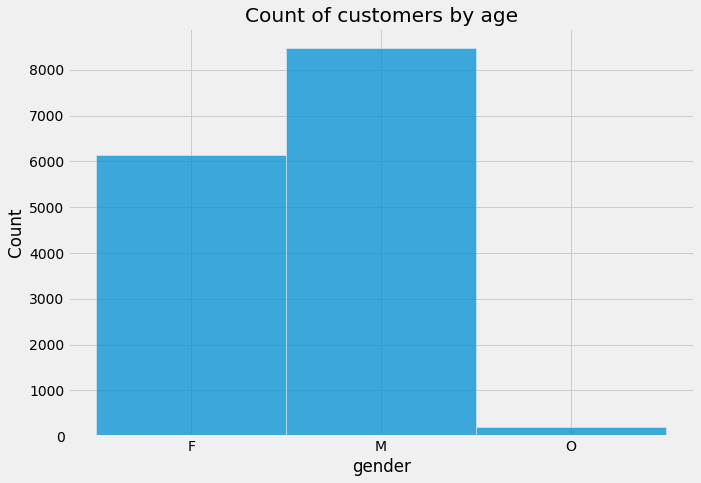

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.histplot(data, x="gender", bins = 10);
plt.title('Count of customers by age')

Text(0.5, 1.0, 'Count of customers by year joined')

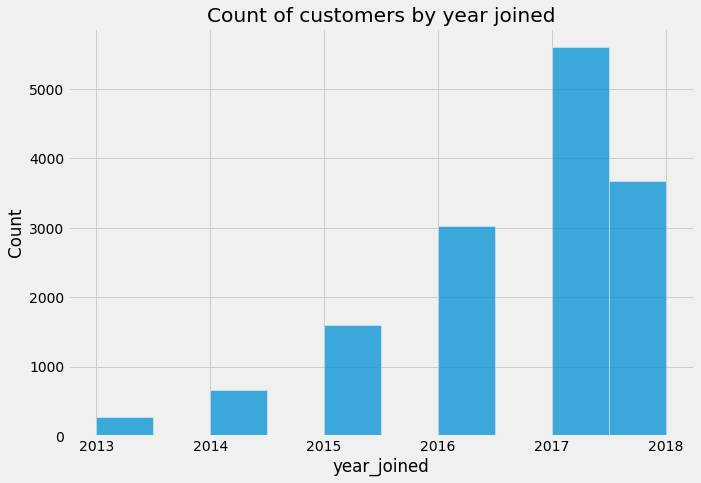

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data, x="year_joined", bins = 10);
plt.title('Count of customers by year joined')

## 7.1) Cohort Analysis - Feature Engineering <a class="anchor" id="eda_cohort"></a>

### 7.1.1) Age cohort <a class="anchor" id="age_cohort"></a>

There is a lot of research done and published on the fields of psychology and marketing on human behavior based on the idea of generational cohorts, such as the 'baby boomers', generation X, Y and Z, and others. We are going to use these cohorts for this analysis, since this data analysis is marketing-related.

Age stratification:

* 18 - 28 - Gen Z

* 29 - 39 - Gen Y

* 40 - 58 - Gen X

* 59 - 75 - Baby boomers

* 76+ - Post-War Cohort

Sources: http://socialmarketing.org/archives/generations-xy-z-and-the-others/

https://www.kasasa.com/exchange/articles/generations/gen-x-gen-y-gen-z

https://www.wordstream.com/blog/ws/2016/09/28/generational-marketing-tactics

In [15]:
def age_groups(row):
    if row['age'] >= 18 and row['age'] < 29:
        val = 'Gen Z (18 - 29)'
    elif row['age'] >= 29 and row['age'] < 40:
        val = 'Gen Y (29 - 39)'
    elif row['age'] >= 40 and row['age'] < 59:
        val = 'Gen X (40 - 58)'
    elif row['age'] >= 59 and row['age'] < 75:
        val = 'Baby boomers (59 - 75)'   
    else:
        val = 'Post-War Cohort (76+)'
    return val

In [16]:
#create new column 'Good' using the function above
data['age_range'] = data.apply(age_groups, axis=1)

In [17]:
data.head()

,gender,age,customer_id,became_member_on,income,year_joined,offer_1_complete,offer_2_complete,offer_4_complete,offer_5_complete,...,offer_bogo_ignored,offer_discount_ignored,offer_8_ignored,offer_3_ignored,amount,reward,offer_info_ignored,offers_ignored,accident_completion,age_range
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,77.01,5.0,0.0,0.0,1.0,Gen X (40 - 58)
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,159.27,20.0,0.0,0.0,0.0,Post-War Cohort (76+)
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,57.73,7.0,0.0,1.0,0.0,Baby boomers (59 - 75)
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,0.0,0.0,2.0,0.0,...,2.0,0.0,0.0,0.0,36.43,19.0,0.0,2.0,0.0,Baby boomers (59 - 75)
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,15.62,2.0,0.0,1.0,0.0,Gen X (40 - 58)


Text(0.5, 1.0, 'Count of customers by age and gender')

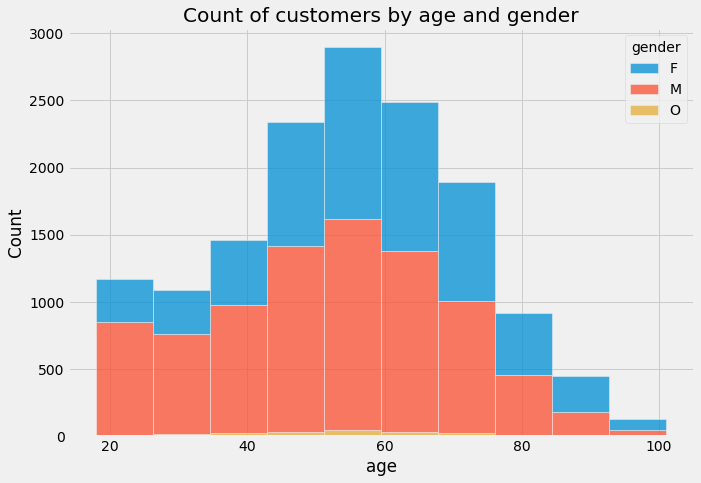

In [18]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data, x="age", hue="gender", bins = 10, multiple="stack");
plt.title('Count of customers by age and gender')

Text(0.5, 1.0, 'Count of customers by age and gender')

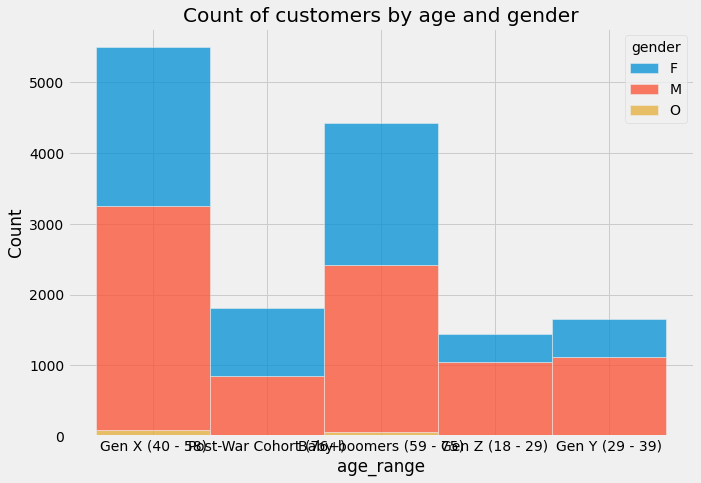

In [19]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data, x="age_range", hue="gender", bins = 10, multiple="stack");
plt.title('Count of customers by age and gender')

### 7.1.2) Income Cohort <a class="anchor" id="income_cohort"></a>

We are going to use Equifax's definition of income cohort:

* < 50k - Low income

* 50 - 75k - Moderate Income lower end

* 75 - 100k - Moderate Income upper end

* '> 100k - High Income



Sources: https://datadrivenmarketing.equifax.com/economic-cohorts/

In [20]:
print("Starbucks App user income is between {} and {} dollars"
      .format(data['income'].min(), data['income'].max()))

Starbucks App user income is between 30000.0 and 120000.0 dollars


In [21]:
def income_cohort(row):
    if row['income'] <= 50000:
        val = 'Low income'
    elif row['income'] > 50000 and row['income'] <= 75000:
        val = 'Moderate Income lower end'
    elif row['income'] > 75000 and row['income'] < 100000:
        val = 'Moderate Income upper end'
    else:
        val = 'High Income'
    return val

In [22]:
#create new column 'Good' using the function above
data['income_cohort'] = data.apply(income_cohort, axis=1)

In [106]:
plt.rc('font', size=10)

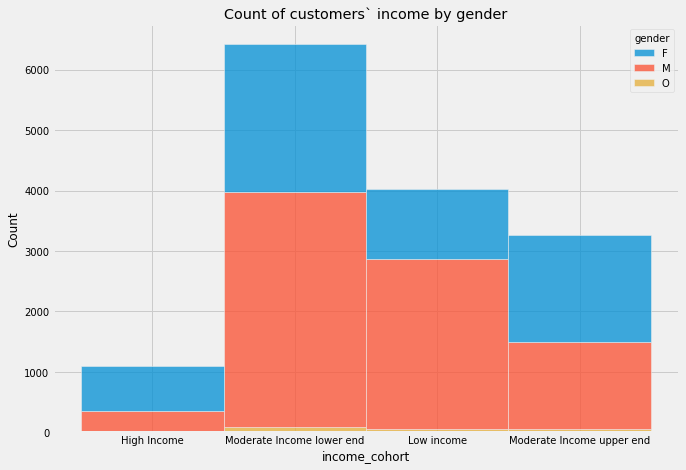

In [107]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data, x="income_cohort", hue="gender", bins = 10, multiple="stack");
plt.title('Count of customers` income by gender');

In [24]:
data.shape

(14825, 48)

In [25]:
data.groupby('income_cohort')['customer_id'].count()

income_cohort
High Income                  1093
Low income                   4034
Moderate Income lower end    6436
Moderate Income upper end    3262
Name: customer_id, dtype: int64

In [26]:
print("High income represents {} % of the users".format(1093/14825 * 100))
print("Low income represents {} % of the users".format(4034/14825 * 100))
print("Moderate Income lower end represents {} % of the users".format(6436/14825 * 100))
print("Moderate Income upper end represents {} % of the users".format(3262/14825*100))

High income represents 7.3726812816188865 % of the users
Low income represents 27.210792580101177 % of the users
Moderate Income lower end represents 43.413153456998316 % of the users
Moderate Income upper end represents 22.00337268128162 % of the users


In [27]:
plt.rc('font', size=10)

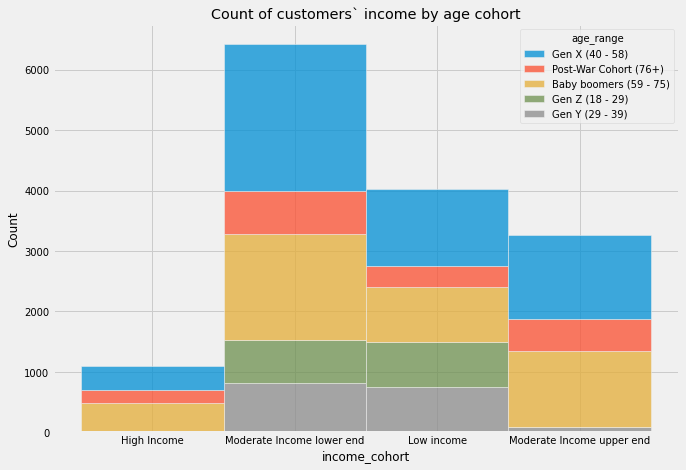

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data, x="income_cohort", hue="age_range", multiple="stack", ax = ax);
plt.title('Count of customers` income by age cohort');

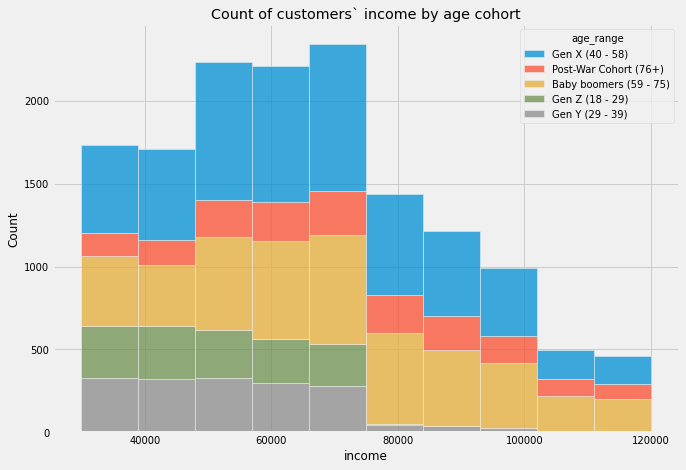

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data, x="income", hue="age_range", bins = 10, multiple="stack");
plt.title('Count of customers` income by age cohort');

## Main takeaways after applying cohorts on age and income and initial look at the data

1) The majority of individuals in the dataset are male

2) The majority of the sample that comprehends this dataset are Generation X individuals (between 40 - 58 years old) 

3) Regarding income, the majority of the sample that comprehends this dataset is composed of individuals that earn between 50k - 75k (moderate income - lower end)

4) Majority of users joined the app after 2016

5) I am aware that for this project this is simulated data for the sake of the exercise, but it is important to note that ideally this population should be representative of the Starbucks customers; if this is not known, it could be useful to use USA's population distribution as reference. This data seems to be biased towards having certain stratum of the population

## General view on the completion of different types of offers <a class="anchor" id="general_view"></a>

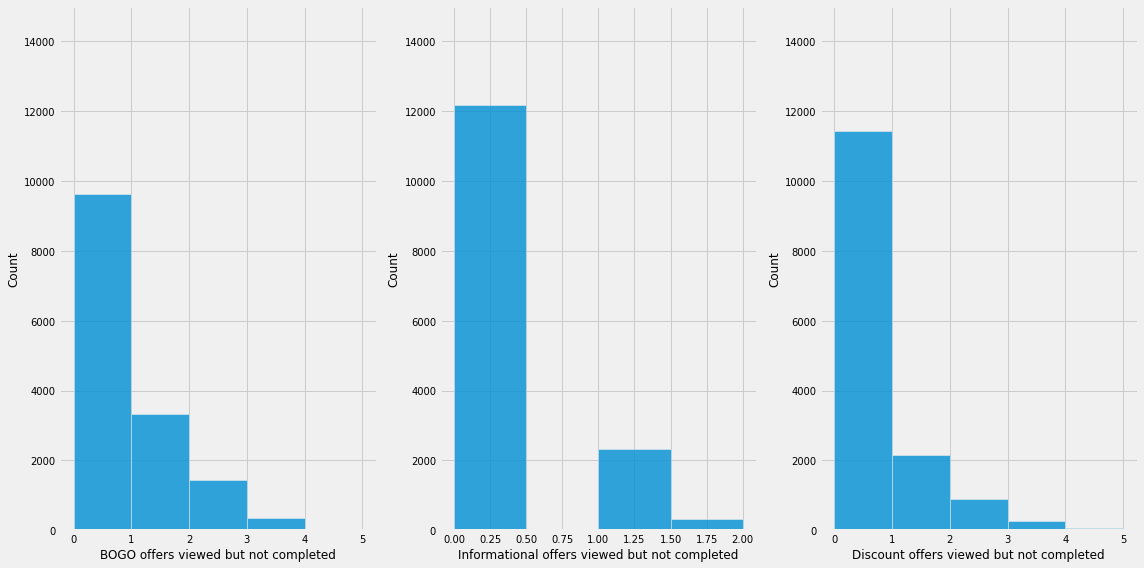

In [30]:
f, axs = plt.subplots(1, 3, figsize=(16, 8))
sns.histplot(data=data, x="offer_bogo_ignored", alpha=.8, legend=False,
             binwidth = 1, ax=axs[0])
sns.histplot(data=data, x="offer_info_ignored", alpha=.8, legend=False,
             binwidth = 0.5, ax=axs[1])
sns.histplot(data=data, x="offer_discount_ignored", alpha=.8, legend=False,
             binwidth = 1, ax=axs[2])

axs[0].set(xlabel='BOGO offers viewed but not completed', ylabel='Count')
axs[0].set(ylim=(0, 15000))
axs[1].set(xlabel='Informational offers viewed but not completed', ylabel='Count')
axs[1].set(ylim=(0, 15000))
axs[2].set(xlabel='Discount offers viewed but not completed', ylabel='Count')
axs[2].set(ylim=(0, 15000))


f.tight_layout()

In [31]:
bogo_ids = [1,2,4,9]
discount_ids = [5,6,7,10]
info_ids = [3,8]

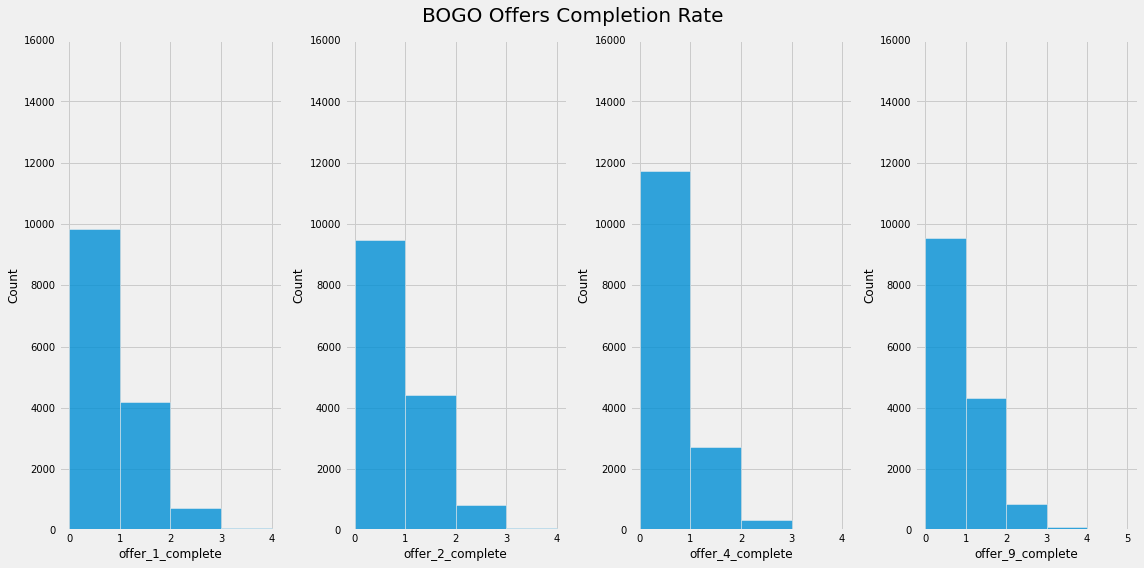

In [32]:
f, axs = plt.subplots(1, len(bogo_ids), figsize=(16, 8))
for idx in range(len(bogo_ids)):
    sns.histplot(data=data, x="offer_{}_complete".format(bogo_ids[idx]),
                 alpha=.8, legend=False,
                 binwidth = 1, ax = axs[idx])
    axs[idx].set(ylim=(0, 16000))
    
f.suptitle('BOGO Offers Completion Rate', fontsize=20)
f.tight_layout()

#### In general, all bogo offers seems to be very popular; offers 2 and 9 seem to take a slight advantage as the favorites

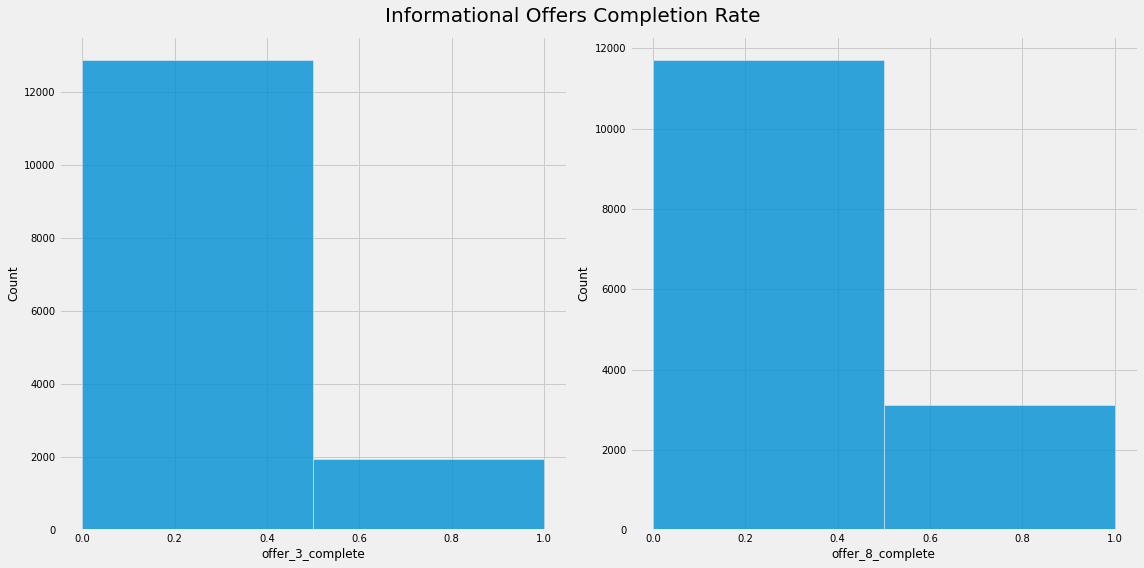

In [33]:
f, axs = plt.subplots(1, len(info_ids), figsize=(16, 8))
for idx in range(len(info_ids)):
    sns.histplot(data=data, x="offer_{}_complete".format(info_ids[idx]),
                 alpha=.8, legend=False, ax = axs[idx], bins = 2)
    
    
f.suptitle('Informational Offers Completion Rate', fontsize=20)
f.tight_layout()

#### Offer 8 is a favourite among the informational

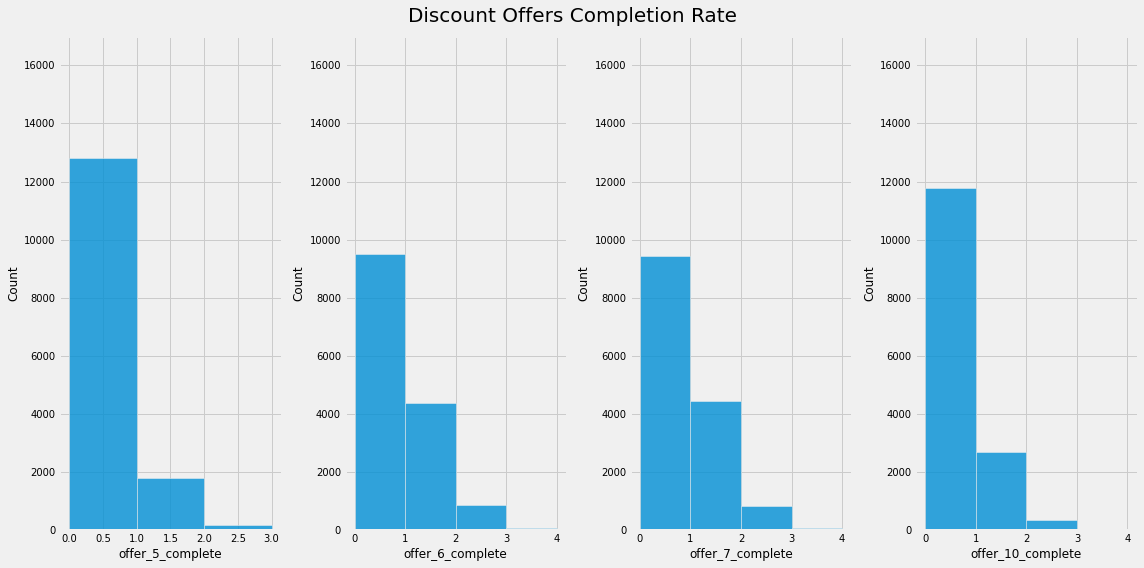

In [34]:
f, axs = plt.subplots(1, len(discount_ids), figsize=(16, 8))
for idx in range(len(discount_ids)):
    sns.histplot(data=data, x="offer_{}_complete".format(discount_ids[idx]),
                 alpha=.8, legend=False,
                 binwidth = 1, ax = axs[idx])
    
    axs[idx].set(ylim=(0, 17000))
    
f.suptitle('Discount Offers Completion Rate', fontsize=20)
f.tight_layout()

#### Offer 10 is the most popular offer among the discount offers

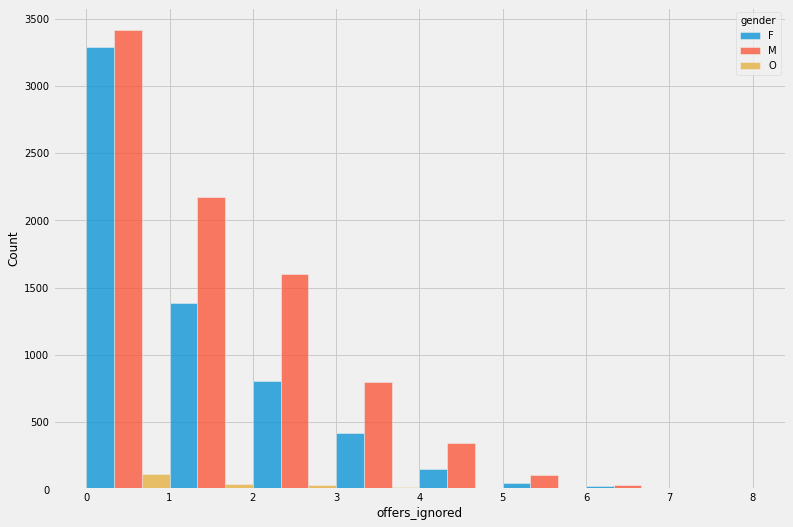

In [35]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(data, x="offers_ignored", hue="gender", multiple = 'dodge',
            binwidth = 1);

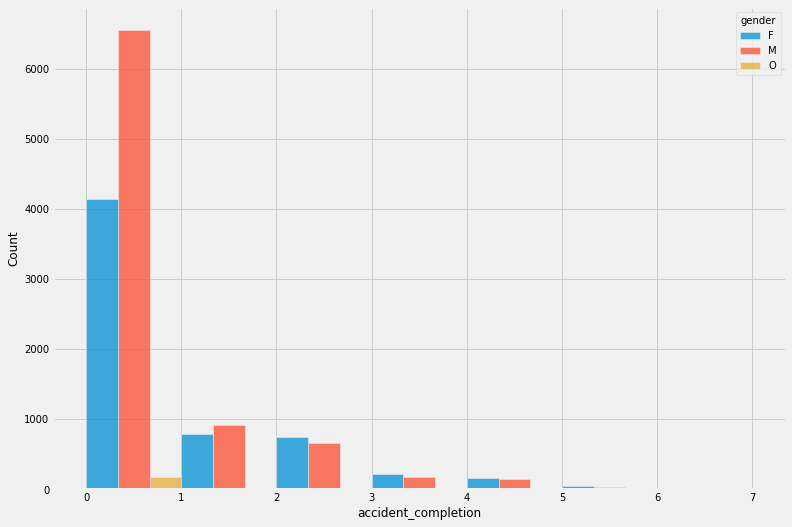

In [36]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.histplot(data, x="accident_completion", hue="gender", multiple = 'dodge',
            binwidth = 1);

In [37]:
#fig, ax = plt.subplots(figsize=(11.7, 8.27))
#sns.histplot(data, x="income", hue="accident_completion", multiple = 'stack');

In [38]:
data_complete = data[['offer_1_complete',
 'offer_2_complete',
 'offer_3_complete',
 'offer_4_complete',
 'offer_5_complete',
 'offer_6_complete',
 'offer_7_complete',
 'offer_8_complete',
 'offer_9_complete',
 'offer_10_complete']]
data_complete.head()

,offer_1_complete,offer_2_complete,offer_3_complete,offer_4_complete,offer_5_complete,offer_6_complete,offer_7_complete,offer_8_complete,offer_9_complete,offer_10_complete
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [39]:
a = data_complete.sum().reset_index()
a

,index,0
0,offer_1_complete,5901.0
1,offer_2_complete,6329.0
2,offer_3_complete,1950.0
3,offer_4_complete,3499.0
4,offer_5_complete,2215.0
5,offer_6_complete,6379.0
6,offer_7_complete,6407.0
7,offer_8_complete,3110.0
8,offer_9_complete,6310.0
9,offer_10_complete,3460.0


In [40]:
a.columns

Index(['index', 0], dtype='object')

In [41]:

a.rename({'index': 'offer'}, axis = 1, inplace = True)
a.rename({0: 'sum'}, axis = 1, inplace = True)
a.sort_values(by = 'sum')

,offer,sum
2,offer_3_complete,1950.0
4,offer_5_complete,2215.0
7,offer_8_complete,3110.0
9,offer_10_complete,3460.0
3,offer_4_complete,3499.0
0,offer_1_complete,5901.0
8,offer_9_complete,6310.0
1,offer_2_complete,6329.0
5,offer_6_complete,6379.0
6,offer_7_complete,6407.0


In [42]:
a.sum()

offer    offer_1_completeoffer_2_completeoffer_3_comple...
sum                                                  45560
dtype: object

In [43]:
a['offer']

0     offer_1_complete
1     offer_2_complete
2     offer_3_complete
3     offer_4_complete
4     offer_5_complete
5     offer_6_complete
6     offer_7_complete
7     offer_8_complete
8     offer_9_complete
9    offer_10_complete
Name: offer, dtype: object

### What are the most popular offers?

/Users/lucasmaretti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


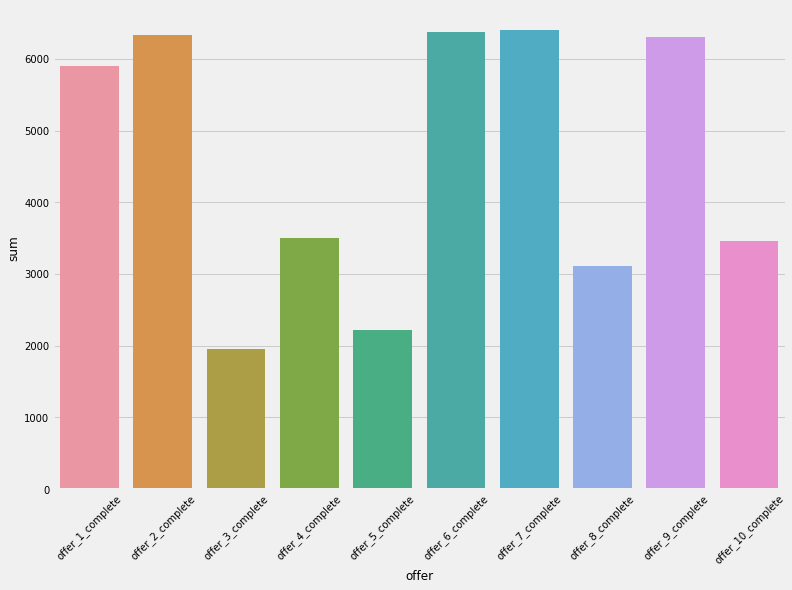

In [44]:
#What are the most and least popular offers?

fig, ax = plt.subplots(figsize=(11.7, 8.27))

ax.set_xticklabels(labels=a['offer'],rotation=45);

sns.barplot(data = a, x = 'offer', y = 'sum');

We have 5 major popular offers that stand out among the 10:

* offer 1: BOGO

* offer 2: BOGO

* offer 6: Discount

* offer 7: Discount

* offer 9: BOGO

Percentage-wise, those 3 BOGO offers account for 40% of all offers completed. Clearly there is something going on there.

Combining the 3 bogo offers (1, 2 and 9) and analysing demographics:

In [45]:
bogo_complete = data[(data['offer_2_complete'] == 1) | (data['offer_1_complete'] == 1) | (data['offer_9_complete'] == 1)]

Text(0.5, 1.0, 'Count of customers by gender for top bogo offers (1, 2 and 9)')

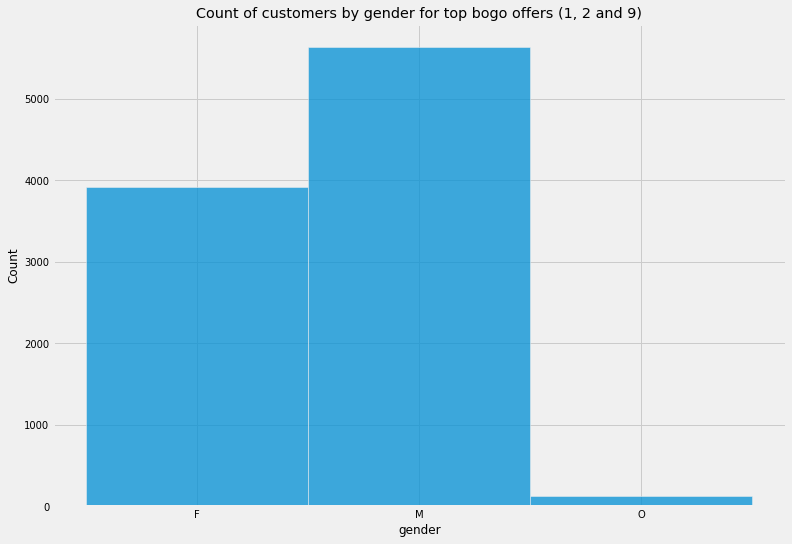

In [46]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(bogo_complete, x="gender", bins = 10);
plt.title('Count of customers by gender for top bogo offers (1, 2 and 9)')

Text(0.5, 1.0, 'Count of customers by age for top bogo offers (1, 2 and 9)')

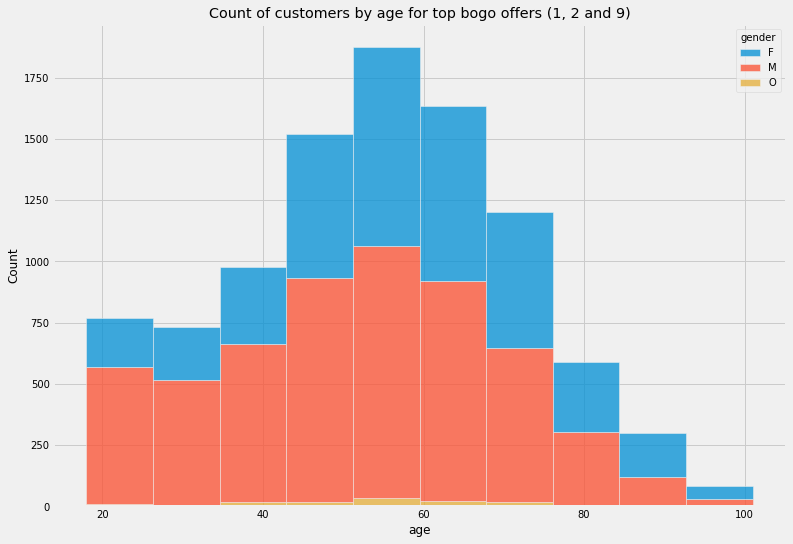

In [47]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(bogo_complete, x="age", hue = 'gender', multiple = 'stack',bins = 10);
plt.title('Count of customers by age for top bogo offers (1, 2 and 9)')

Text(0.5, 1.0, 'Count of customers by income cohort for top bogo offers (1, 2 and 9)')

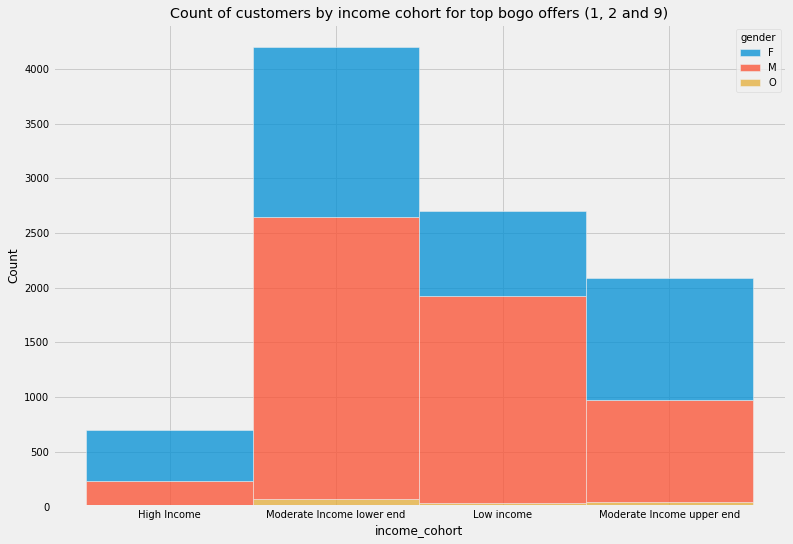

In [48]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(bogo_complete, x="income_cohort", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers by income cohort for top bogo offers (1, 2 and 9)')

Text(0.5, 1.0, 'Count of customers by age and income cohort for top bogo offers (1, 2 and 9)')

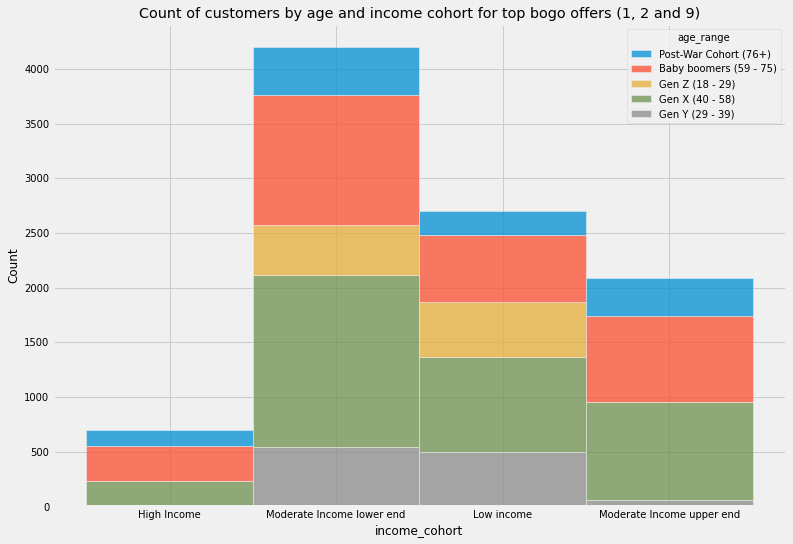

In [49]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(bogo_complete, x="income_cohort", hue = 'age_range',multiple = 'stack', bins = 10);
plt.title('Count of customers by age and income cohort for top bogo offers (1, 2 and 9)')

Text(0.5, 1.0, 'Count of customers by age cohort for top bogo offers (1, 2 and 9)')

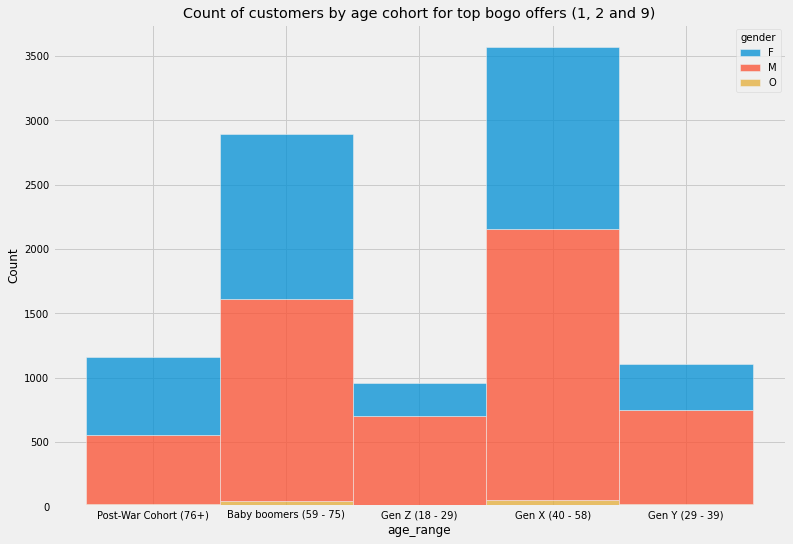

In [50]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(bogo_complete, x="age_range", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers by age cohort for top bogo offers (1, 2 and 9)')

In [51]:
bogo_complete.shape

(9688, 48)

In [52]:
bogo_complete.groupby('income_cohort')['customer_id'].count()

income_cohort
High Income                   698
Low income                   2703
Moderate Income lower end    4201
Moderate Income upper end    2086
Name: customer_id, dtype: int64

In [53]:
print("High income represents {} % of the users who completed offers 1,2 and 9".format(698/9688 * 100))
print("Low income represents {} % of the users who completed offers 1,2 and 9".format(2703/9688 * 100))
print("Moderate Income lower end represents {} % of the users who completed offers 1,2 and 9".format(4201/9688 * 100))
print("Moderate Income upper end represents {} % of the users who completed offers 1,2 and 9".format(2086/9688*100))

High income represents 7.204789430222956 % of the users who completed offers 1,2 and 9
Low income represents 27.900495458298924 % of the users who completed offers 1,2 and 9
Moderate Income lower end represents 43.36292320396367 % of the users who completed offers 1,2 and 9
Moderate Income upper end represents 21.53179190751445 % of the users who completed offers 1,2 and 9


In [54]:
print("High income represents {} % of the total number of users".format(1093/14825 * 100))
print("Low income represents {} % of the total number of users".format(4034/14825 * 100))
print("Moderate Income lower end represents {} % of the total number of users".format(6436/14825 * 100))
print("Moderate Income upper end represents {} % of the total number of users".format(3262/14825*100))

High income represents 7.3726812816188865 % of the total number of users
Low income represents 27.210792580101177 % of the total number of users
Moderate Income lower end represents 43.413153456998316 % of the total number of users
Moderate Income upper end represents 22.00337268128162 % of the total number of users


Heuristic:

* BOGO offers 1,2 and 9 have great appeal to males between 40 - 58 years old who earn between 50 - 75k

In [55]:
discount_complete = data[(data['offer_6_complete'] == 1) | (data['offer_7_complete'] == 1)]

Text(0.5, 1.0, 'Count of customers by gender for top discount offers (6 and 7)')

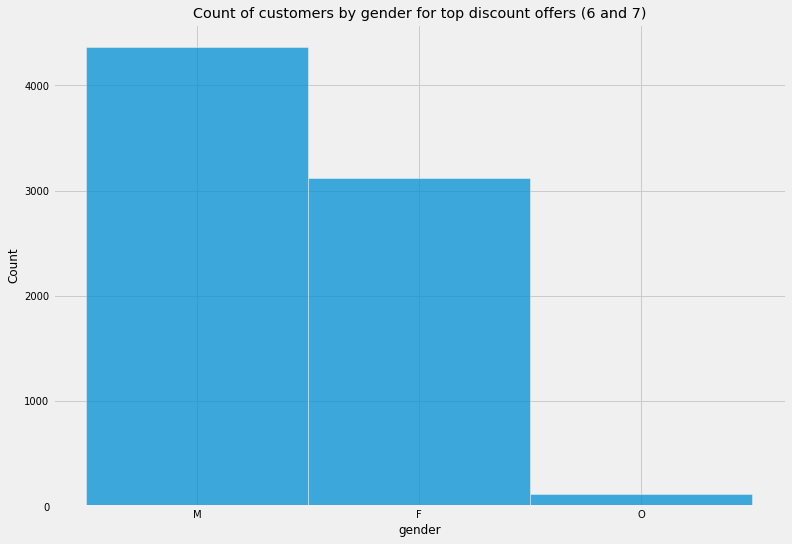

In [56]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(discount_complete, x="gender", bins = 10);
plt.title('Count of customers by gender for top discount offers (6 and 7)')

Text(0.5, 1.0, 'Count of customers by gender for top discount offers (6 and 7)')

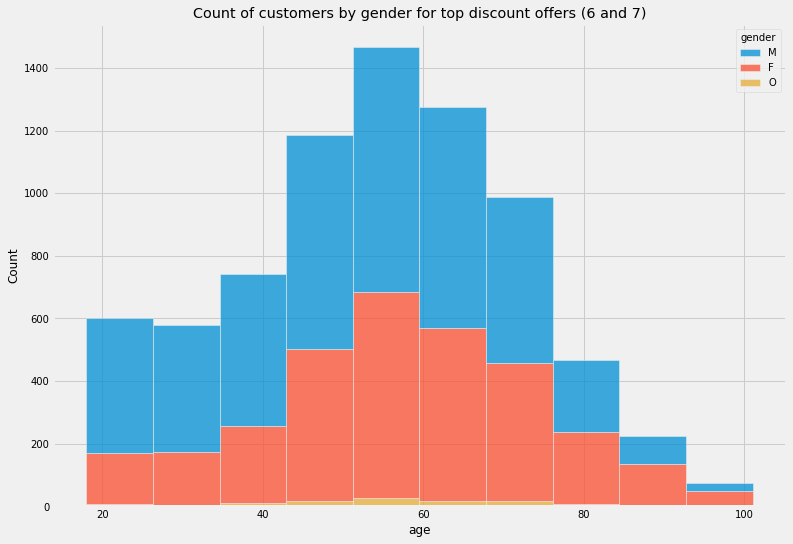

In [57]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(discount_complete, x="age", hue = 'gender', multiple = 'stack',bins = 10);
plt.title('Count of customers by gender for top discount offers (6 and 7)')

Text(0.5, 1.0, 'Count of customers by gender for top discount offers (6 and 7)')

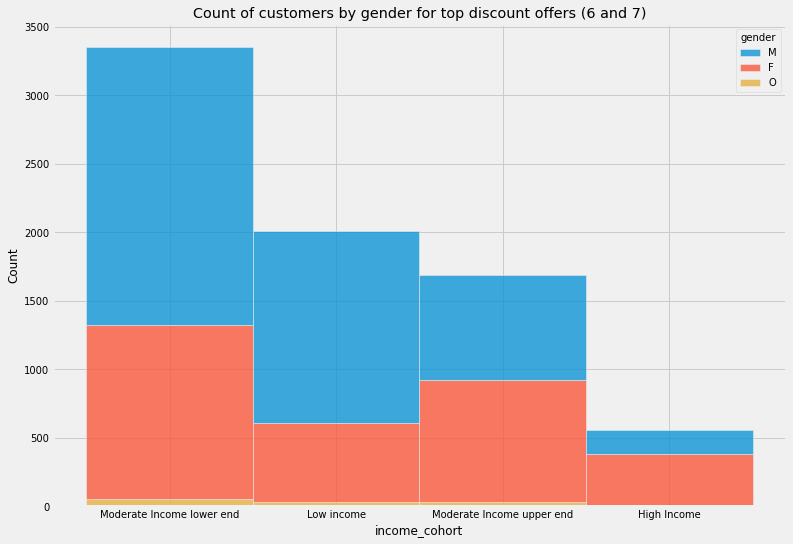

In [58]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(discount_complete, x="income_cohort", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers by gender for top discount offers (6 and 7)')

Text(0.5, 1.0, 'Count of customers by gender for top discount offers (6 and 7)')

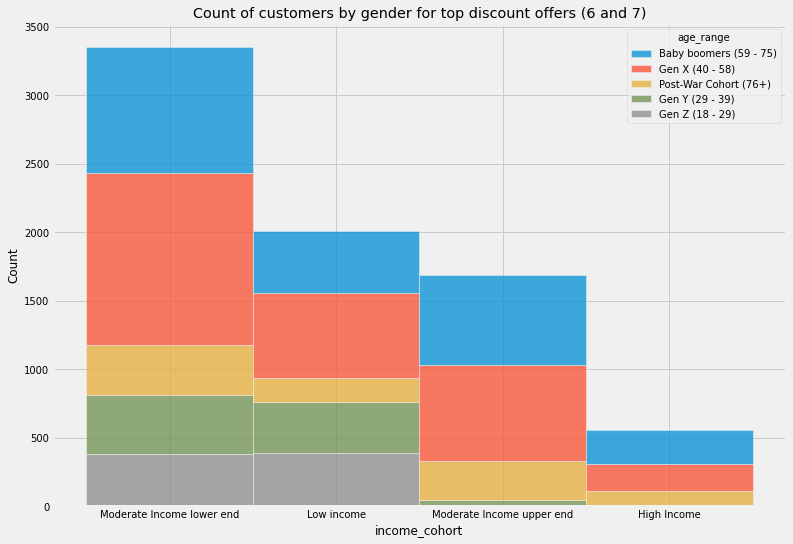

In [59]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(discount_complete, x="income_cohort", hue = 'age_range',multiple = 'stack', bins = 10);
plt.title('Count of customers by gender for top discount offers (6 and 7)')

Text(0.5, 1.0, 'Count of customers by gender for top discount offers (6 and 7)')

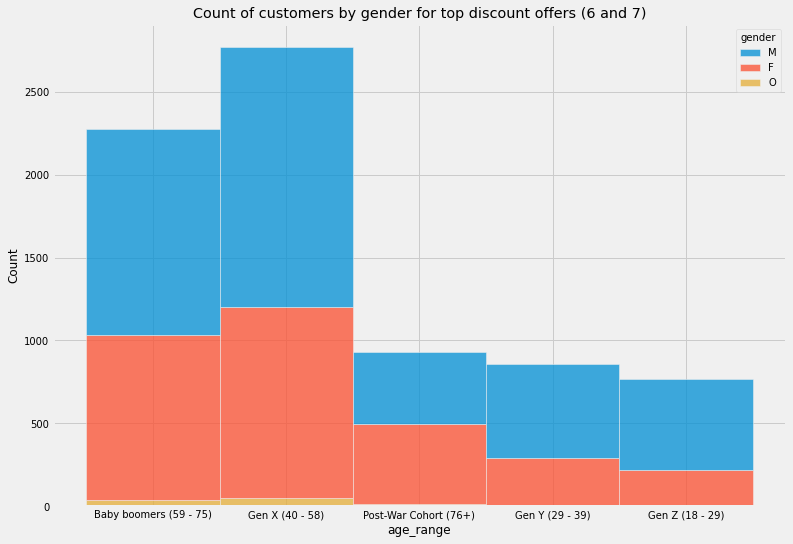

In [60]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(discount_complete, x="age_range", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers by gender for top discount offers (6 and 7)')

In [61]:
discount_complete.shape

(7603, 48)

In [62]:
discount_complete.groupby('income_cohort')['customer_id'].count()

income_cohort
High Income                   558
Low income                   2007
Moderate Income lower end    3353
Moderate Income upper end    1685
Name: customer_id, dtype: int64

In [63]:
print("High income represents {} % of the users who completed offers 6 and 7".format(558/7603 * 100))
print("Low income represents {} % of the users who completed offers 6 and 7".format(2007/7603 * 100))
print("Moderate Income lower end represents {} % of the users who completed offers 6 and 7".format(3353/7603 * 100))
print("Moderate Income upper end represents {} % of the users who completed offers 6 and 7".format(1685/7603*100))

High income represents 7.339208207286598 % of the users who completed offers 6 and 7
Low income represents 26.397474681046955 % of the users who completed offers 6 and 7
Moderate Income lower end represents 44.1010127581218 % of the users who completed offers 6 and 7
Moderate Income upper end represents 22.162304353544656 % of the users who completed offers 6 and 7


### What are the offers that got accidentaly completed the most?

In [64]:
b = data[['accident_1', 'accident_2', 'accident_4', 'accident_5', 'accident_6', 'accident_7',
                      'accident_9', 'accident_10']]

In [65]:
b = b.sum().reset_index()
b

,index,0
0,accident_1,471.0
1,accident_2,112.0
2,accident_4,1598.0
3,accident_5,1821.0
4,accident_6,207.0
5,accident_7,180.0
6,accident_9,150.0
7,accident_10,1381.0


In [66]:
b.rename({'index': 'offer'}, axis = 1, inplace = True)
b.rename({0: 'sum'}, axis = 1, inplace = True)
b.sort_values(by = 'sum')

,offer,sum
1,accident_2,112.0
6,accident_9,150.0
5,accident_7,180.0
4,accident_6,207.0
0,accident_1,471.0
7,accident_10,1381.0
2,accident_4,1598.0
3,accident_5,1821.0


/Users/lucasmaretti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


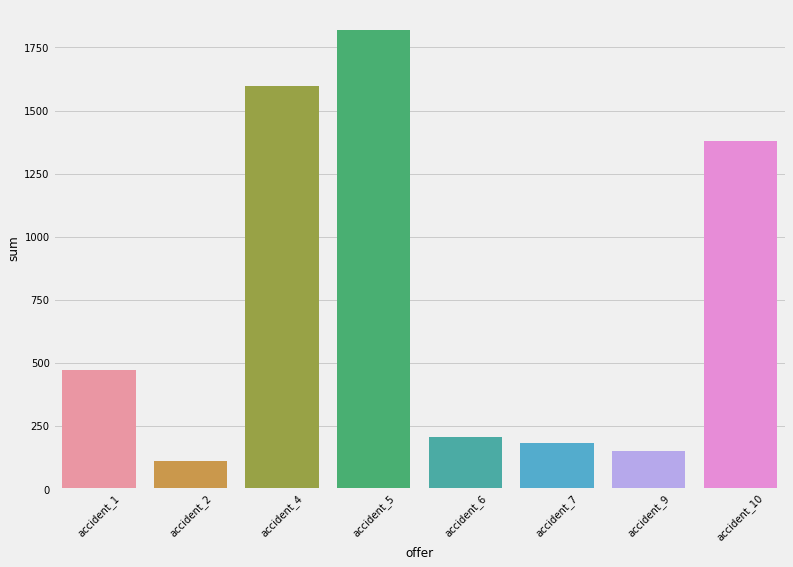

In [67]:
#What are the most and least popular offers?

fig, ax = plt.subplots(figsize=(11.7, 8.27))

ax.set_xticklabels(labels=a['offer'],rotation=45);

sns.barplot(data = b, x = 'offer', y = 'sum');

We have 3 major popular offers that stand out among the 10 for accident completion:

* offer 4: BOGO

* offer 5: Discount

* offer 10: Discount

The 3 offers do not use social media as a channel for marketing

We are going to separate the analysis because the offers have significant differences among themselves:

* Offer 5 is the most difficult, so we will analyse it separately

* Offers 4 and 10 will be analyzed together as they are similar

In [68]:
acc5 = data[(data['accident_5'] == 1)]

Text(0.5, 1.0, 'Count of customers by age for accident completion on offer 5')

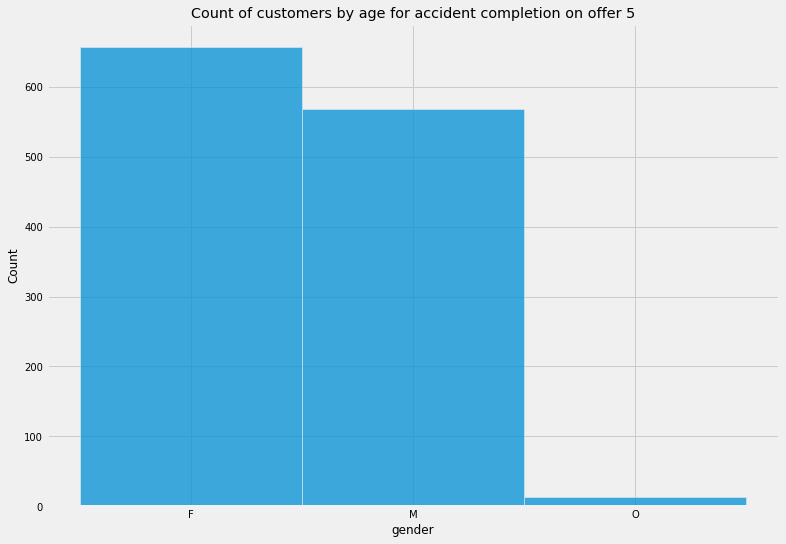

In [69]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc5, x="gender", bins = 10);
plt.title('Count of customers by age for accident completion on offer 5')

Text(0.5, 1.0, 'Count of customers by age for accident completion on offer 5')

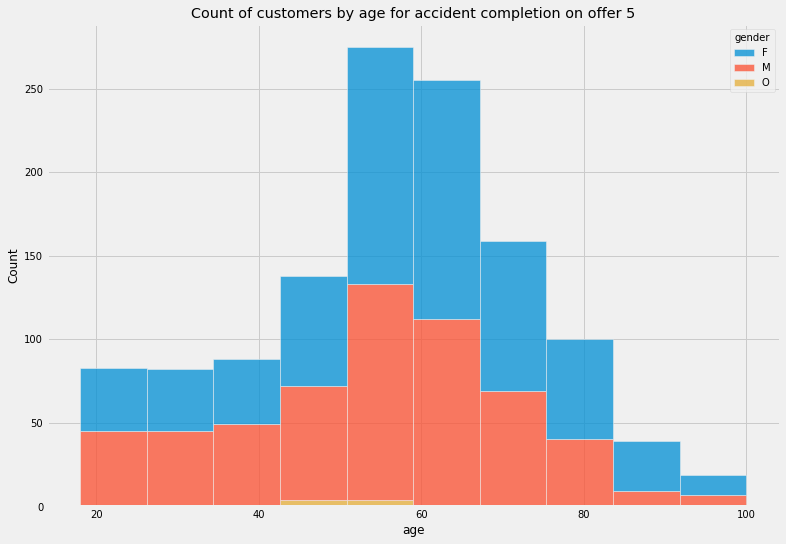

In [70]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc5, x="age", hue = 'gender', multiple = 'stack',bins = 10);
plt.title('Count of customers by age for accident completion on offer 5')

Text(0.5, 1.0, 'Count of customers by age for accident completion on offer 5')

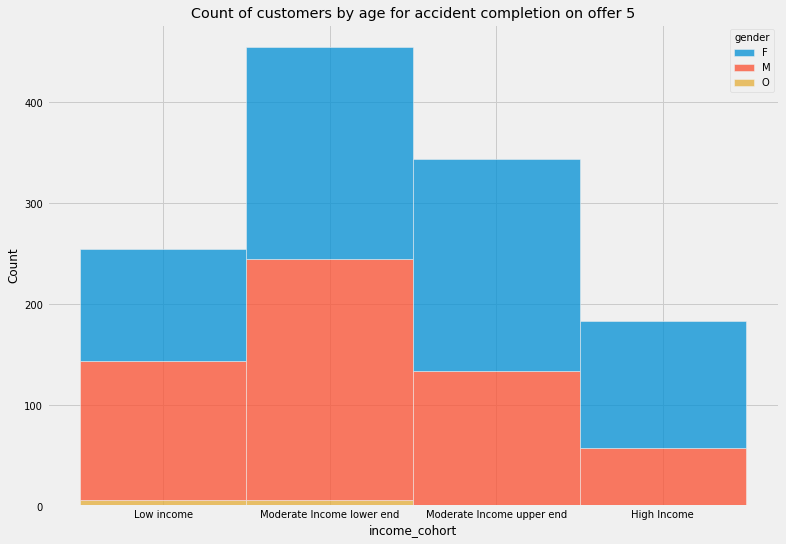

In [71]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc5, x="income_cohort", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers by age for accident completion on offer 5')

Text(0.5, 1.0, 'Count of customers by age for accident completion on offer 5')

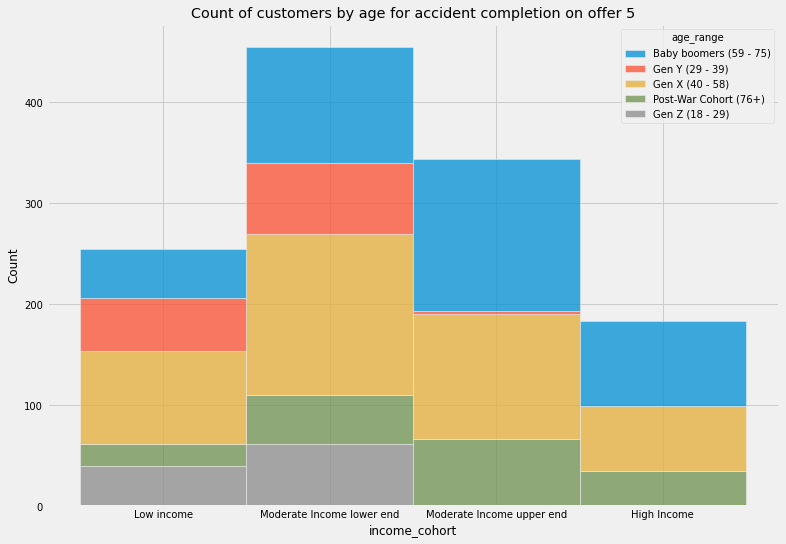

In [72]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc5, x="income_cohort", hue = 'age_range',multiple = 'stack', bins = 10);
plt.title('Count of customers by age for accident completion on offer 5')

In [73]:
acc5.shape

(1238, 48)

In [74]:
acc5.groupby('income_cohort')['customer_id'].count()

income_cohort
High Income                  184
Low income                   255
Moderate Income lower end    455
Moderate Income upper end    344
Name: customer_id, dtype: int64

In [75]:
print("High income represents {} % of the users".format(184/1238 * 100))
print("Low income represents {} % of the users".format(255/1238 * 100))
print("Moderate Income lower end represents {} % of the users".format(455/1238 * 100))
print("Moderate Income upper end represents {} % of the users".format(344/1238*100))

High income represents 14.862681744749596 % of the users
Low income represents 20.59773828756058 % of the users
Moderate Income lower end represents 36.75282714054927 % of the users
Moderate Income upper end represents 27.78675282714055 % of the users


* Females who earn > 75k and are over 40 years of age have more likelihood to complete by accident discount offer #5, which is the most "difficult"

In [76]:
acc_bd = data[(data['accident_10'] == 1) | (data['accident_4'] == 1)]

Text(0.5, 1.0, 'Count of customers by age for accident completion on offers 4 and 10')

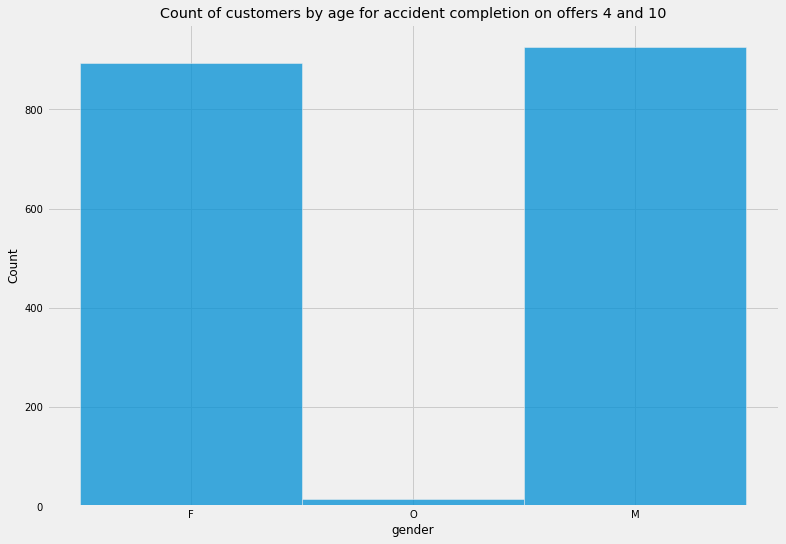

In [77]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc_bd, x="gender", bins = 10);
plt.title('Count of customers by age for accident completion on offers 4 and 10')

Text(0.5, 1.0, 'Count of customers by age for accident completion on offers 4 and 10')

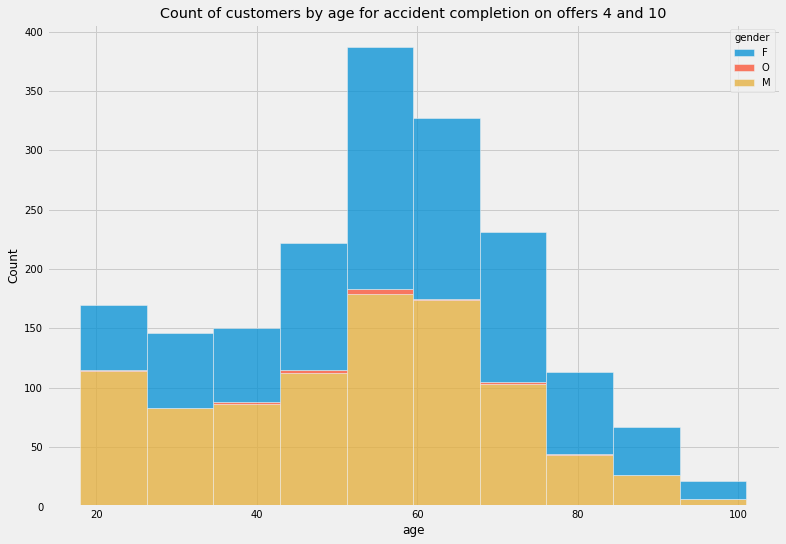

In [78]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc_bd, x="age", hue = 'gender', multiple = 'stack',bins = 10);
plt.title('Count of customers by age for accident completion on offers 4 and 10')

Text(0.5, 1.0, 'Count of customers by age for accident completion on offers 4 and 10')

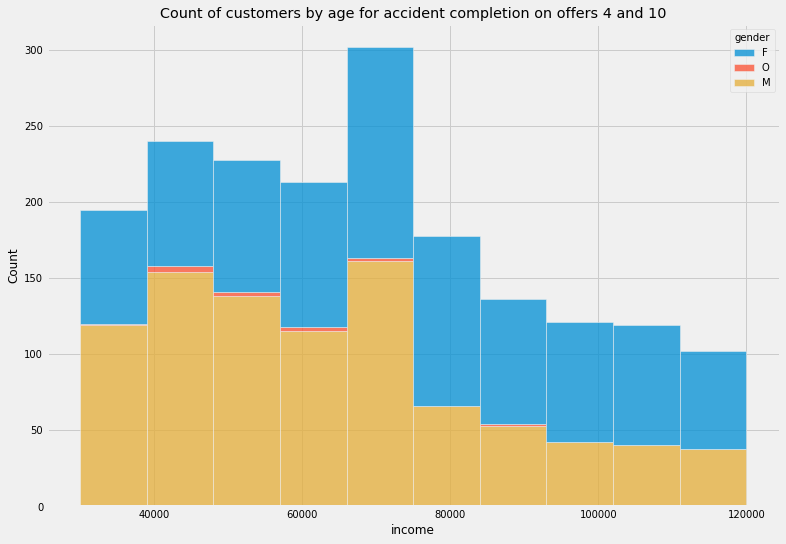

In [79]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc_bd, x="income", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers by age for accident completion on offers 4 and 10')

Text(0.5, 1.0, 'Count of customers by age for accident completion on offers 4 and 10')

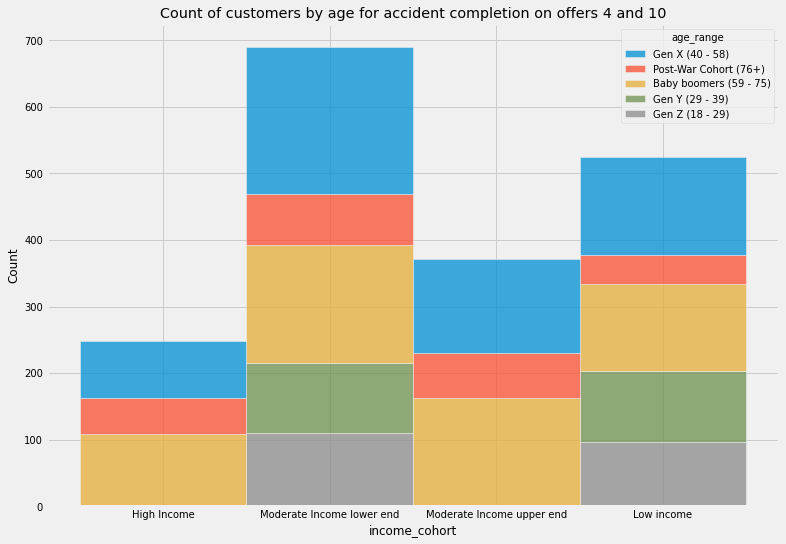

In [80]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(acc_bd, x="income_cohort", hue = 'age_range',multiple = 'stack', bins = 10);
plt.title('Count of customers by age for accident completion on offers 4 and 10')

* Follows general trend of the population, difference being on the channel used for marketing, these did not use the social media

In [81]:
data['total_offers_complete'] = data['offer_bogo_complete'] + data['offer_discount_complete'] + data['offer_informational']

## Cluster analysis <a class="anchor" id="cluster_analysis"></a>

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [83]:
pca = PCA(2)

In [84]:
scaler = StandardScaler()
#top_users[features] = scaler.fit_transform(top_users[features])

One Hot Encoding where needed

In [85]:
data.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income',
       'year_joined', 'offer_1_complete', 'offer_2_complete',
       'offer_4_complete', 'offer_5_complete', 'offer_6_complete',
       'offer_7_complete', 'offer_9_complete', 'offer_10_complete',
       'offer_bogo_complete', 'offer_discount_complete', 'offer_8_complete',
       'offer_3_complete', 'offer_informational', 'accident_1', 'accident_2',
       'accident_4', 'accident_5', 'accident_6', 'accident_7', 'accident_9',
       'accident_10', 'offer_bogo_accidental', 'offer_discount_accidental',
       'ignored_1', 'ignored_2', 'ignored_4', 'ignored_5', 'ignored_6',
       'ignored_7', 'ignored_9', 'ignored_10', 'offer_bogo_ignored',
       'offer_discount_ignored', 'offer_8_ignored', 'offer_3_ignored',
       'amount', 'reward', 'offer_info_ignored', 'offers_ignored',
       'accident_completion', 'age_range', 'income_cohort',
       'total_offers_complete'],
      dtype='object')

In [86]:
df = data.copy()

In [87]:
pd.get_dummies(df['age_range'], prefix='age_range')

,age_range_Baby boomers (59 - 75),age_range_Gen X (40 - 58),age_range_Gen Y (29 - 39),age_range_Gen Z (18 - 29),age_range_Post-War Cohort (76+)
0,0,1,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
14820,0,1,0,0,0
14821,1,0,0,0,0
14822,0,1,0,0,0
14823,0,0,0,0,1


In [88]:
df = pd.concat([df,pd.get_dummies(df['age_range'], prefix='age_range')],axis=1).drop(['age_range'],axis=1)

In [89]:
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gender')],axis=1).drop(['gender'],axis=1)

In [90]:
df = pd.concat([df,pd.get_dummies(df['income_cohort'], prefix='income')],axis=1).drop(['income_cohort'],axis=1)

In [91]:
df.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'year_joined',
       'offer_1_complete', 'offer_2_complete', 'offer_4_complete',
       'offer_5_complete', 'offer_6_complete', 'offer_7_complete',
       'offer_9_complete', 'offer_10_complete', 'offer_bogo_complete',
       'offer_discount_complete', 'offer_8_complete', 'offer_3_complete',
       'offer_informational', 'accident_1', 'accident_2', 'accident_4',
       'accident_5', 'accident_6', 'accident_7', 'accident_9', 'accident_10',
       'offer_bogo_accidental', 'offer_discount_accidental', 'ignored_1',
       'ignored_2', 'ignored_4', 'ignored_5', 'ignored_6', 'ignored_7',
       'ignored_9', 'ignored_10', 'offer_bogo_ignored',
       'offer_discount_ignored', 'offer_8_ignored', 'offer_3_ignored',
       'amount', 'reward', 'offer_info_ignored', 'offers_ignored',
       'accident_completion', 'total_offers_complete',
       'age_range_Baby boomers (59 - 75)', 'age_range_Gen X (40 - 58)',
       'age_range_Gen Y (29 - 

In [92]:
features = ['offer_bogo_accidental', 'offer_discount_accidental','age_range_Baby boomers (59 - 75)', 
        'age_range_Gen X (40 - 58)',
       'age_range_Gen Y (29 - 39)', 'age_range_Gen Z (18 - 29)',
       'age_range_Post-War Cohort (76+)', 'gender_F', 'gender_M', 'gender_O',
       'income_High Income', 'income_Low income',
       'income_Moderate Income lower end', 'income_Moderate Income upper end', 
         'offer_discount_complete', 'offer_bogo_complete',  'offer_informational', 'total_offers_complete' ]

In [93]:
df[features].head()

,offer_bogo_accidental,offer_discount_accidental,age_range_Baby boomers (59 - 75),age_range_Gen X (40 - 58),age_range_Gen Y (29 - 39),age_range_Gen Z (18 - 29),age_range_Post-War Cohort (76+),gender_F,gender_M,gender_O,income_High Income,income_Low income,income_Moderate Income lower end,income_Moderate Income upper end,offer_discount_complete,offer_bogo_complete,offer_informational,total_offers_complete
0,1.0,0.0,0,1,0,0,0,1,0,0,1,0,0,0,0.0,0.0,0.0,0.0
1,0.0,0.0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,3.0,1.0,4.0
2,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0,2.0,1.0,0.0,3.0
3,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1,0,2.0,4.0,0.0,6.0
4,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,2.0,0.0,0.0,2.0


In [94]:
df[features] = scaler.fit_transform(df[features])

In [95]:
df_r = pca.fit_transform(df[features])

In [96]:
### Encontrando o número ótimo de clusters usando a regra do cotovelo

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_r)
    sse.append(kmeans.inertia_)

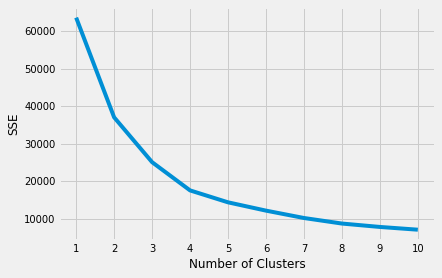

In [97]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [98]:
#######

kmeans = KMeans(
        init="random",
        n_clusters=4,
        n_init=10,
        max_iter=300,
        random_state=42
)

kmeans.fit(df_r)

KMeans(init='random', n_clusters=4, random_state=42)

In [99]:
label = kmeans.fit_predict(df_r)

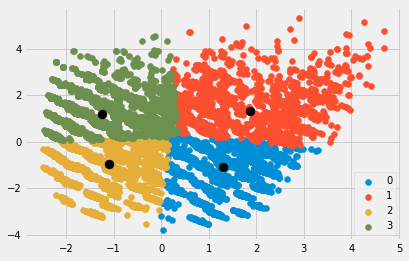

In [100]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df_r[label == i , 0] , df_r[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [101]:
df['cluster'] = kmeans.labels_

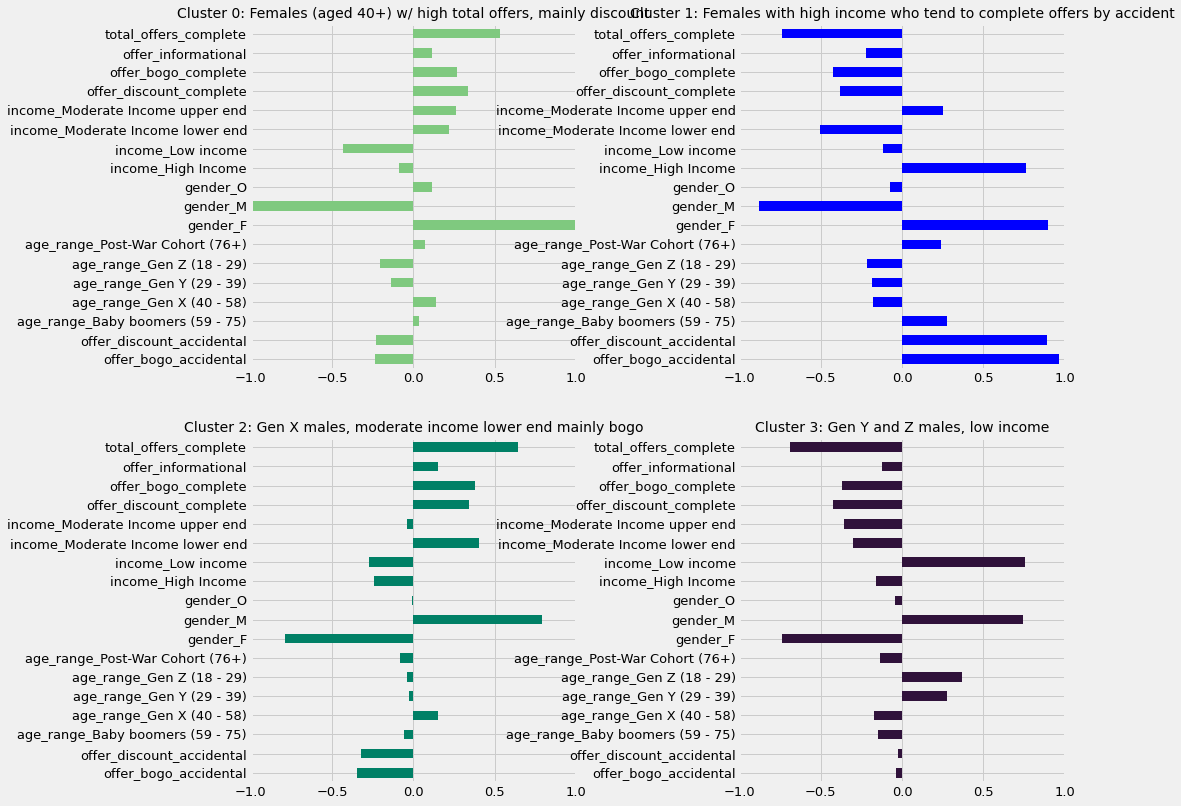

In [105]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,13))

ax1, ax2, ax3, ax4= axes.flatten()

#fig.delaxes(axes[2,1]) #The indexing is zero-based here

fig.subplots_adjust(hspace=.2, wspace=.5)

# top left
df.query('cluster == 0')[features].mean().plot.barh(ax=ax1, colormap=plt.cm.Accent, fontsize=13)
ax1.set_xlim(-1,1)

# top right
df.query('cluster == 1')[features].mean().plot.barh(ax=ax2, colormap='winter', fontsize=13)
ax2.set_xlim(-1,1)

# bottom left
df.query('cluster == 2')[features].mean().plot.barh(ax=ax3, colormap='summer', fontsize=13)
ax3.set_xlim(-1,1)

# bottom right
df.query('cluster == 3')[features].mean().plot.barh(ax=ax4, colormap='turbo', fontsize=13)
ax4.set_xlim(-1,1)


ax1.set_title('Cluster 0: Females (aged 40+) w/ high total offers, mainly discount', fontsize = 14)
ax2.set_title('Cluster 1: Females with high income who tend to complete offers by accident', fontsize = 14)
ax3.set_title('Cluster 2: Gen X males, moderate income lower end mainly bogo', fontsize = 14)
ax4.set_title('Cluster 3: Gen Y and Z males, low income', fontsize = 14)




plt.show()

In [103]:
younger = data[(data['age_range'] == 'Gen Y (29 - 39)') | (data['age_range'] == 'Gen Z (18 - 29)')]

Text(0.5, 1.0, 'Count of customers of generations Y and Z stratified by income)')

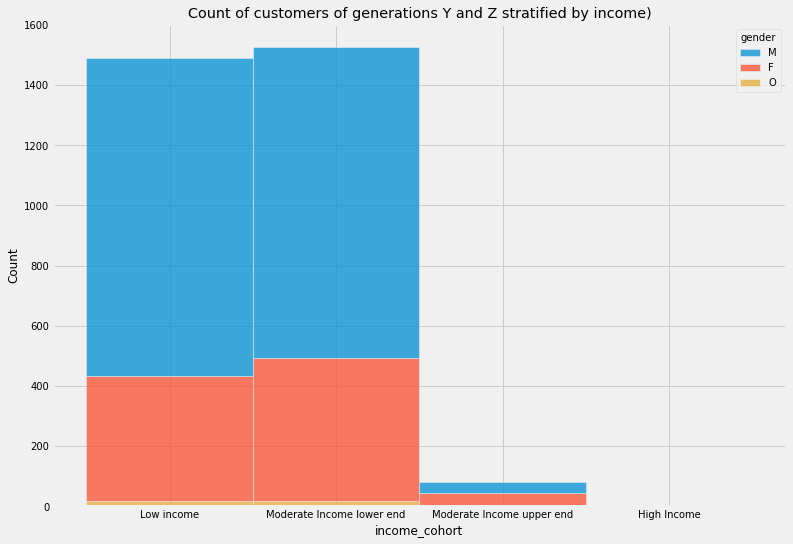

In [104]:
plt.rc('font', size=10)
fig, ax = plt.subplots(figsize=(11.7, 8.27))

sns.histplot(younger, x="income_cohort", hue = 'gender',multiple = 'stack', bins = 10);
plt.title('Count of customers of generations Y and Z stratified by income)')

## 8) Conclusions

The exploratory data analysis along with the clustering analysis were able to provide a comprehensive understanding of Starbucks' customer behavior based on the data of the marketing campaign made available.

It should be noted first that the results obtained and observed are strongly dependent on the sample characteristics of the population of this dataset. As noted earlier, on the gender aspect there is a higher prevalence of males over females (about 30% more males); on the age distribution aspect, there is a much higher presence of individuals with age between 40 and 58. And on the income aspect, the majority of people have income in the range of 50k to 75k USD. The exercise is clear in mentioning that this is simulated data for the sake of testing the algorithms and data science skills, but it felt important to make this remark for the readers' information.

Speaking about the results itself, it became clear that BOGO and Discount offers are two main drivers of when we speak about the customers with elevated rate of offers completed in general. Based on the EDA and clustering analysis, these customers that complete lots of offers can be divided into two main groups:

* 1) Males who belong in the generation X age cohort (40 - 58 years), with moderate income ranging from 50k to 75k USD and who prefer BOGO offers the most.

* 2) Females aged 40+ who prefer mainly discount offers.

The clustering analysis showed interesting trends and allowed for 2 other conclusions (one for each cluster)

First is that the younger portion of the sample - generations Y and Z (18 - 39 years of age) - were the age cohorts that completed offers the least. The above chart shows another skew in the data - this subpopulation is mainly composed of individuals of lower income

Second, regarding accidental completion of offers, one of the clusters is composed of elderly women of high income. And the main characteristic of this cluster is that these individuals are the ones who completed bogo and discount offers by accident the most. So Starbucks should probably not send discounts to these individuals as they tend to purchase anyway.

## 9) Aprendizados